# Michelin Rated Restaurants in France - Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Visualisation functions
from Functions.functions_visualisation import (dataframe_info, filter_dataframe, top_geo_restaurants, 
                                               plot_choropleth, plot_multi_choropleth, plot_area_info)

In [3]:
# Analysis functions
from Functions.functions_analysis import (plot_high_correlations, print_overview_stats, plot_violinplots, 
                                          find_extreme_departments, get_random_restaurants, display_restaurants,
                                          plot_side_by_side)

----
&nbsp;
## We load in the department and *arrondissement* GeoJSON data

In [4]:
# Load GeoJSON departmental data
departments = gpd.read_file("../../data/France/department_restaurants.geojson")
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)', 'locations', 'geometry']


In [5]:
# For pair plots we remove the individual 'star' counts and drop columns for brevity
dept_short = departments.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star', 'starred_restaurants',
                                       'municipal_population', 'GDP_millions(€)', 'area(sq_km)'])

In [6]:
# Load GeoJSON arrondissement data
arrondissements = gpd.read_file("../../data/France/arrondissement_restaurants.geojson")
print(arrondissements.columns.tolist())

['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'locations', 'geometry']


In [7]:
# For pair plots we remove the individual 'star' counts and drop columns for brevity
arron_short = arrondissements.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star',
                                            'starred_restaurants', 'municipal_population'])

----
&nbsp;
# Analysis at Regional Level

Focus on mainland France and therefore Corsica is dropped

In [8]:
regions = dept_short.region.unique().tolist()
regions.remove("Corse")
print(f"Unique Regions:\n{regions}")

Unique Regions:
['Auvergne-Rhône-Alpes', 'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Occitanie', 'Normandie', 'Nouvelle-Aquitaine', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Bretagne', 'Pays de la Loire', 'Île-de-France']


Renaming columns for clarity and concise visualization purposes.

In [9]:
column_dictionary = {'total_stars': 'michelin_stars',
                    'GDP_per_capita(€)': 'per_capita_GDP',
                    'poverty_rate(%)': 'poverty_rate',
                    'average_annual_unemployment_rate(%)': 'unemployment_rate',
                    'average_net_hourly_wage(€)': 'net_wage',
                    'population_density(inhabitants/sq_km)': 'pop_density',
                    }

In [10]:
# Departments
dept_short.rename(columns=column_dictionary, inplace=True)
departments.rename(columns=column_dictionary, inplace=True)

In [11]:
# Arrondissements
arron_short.rename(columns=column_dictionary, inplace=True)
arrondissements.rename(columns=column_dictionary, inplace=True)

----
&nbsp;
## Partitioning data into Northern/Southern France

In [12]:
south_dept = filter_dataframe(dept_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
south_arron = filter_dataframe(arron_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])

In [13]:
# Finding northern regions
s_regions = set(south_dept.region.unique().tolist())
all_regions = set(regions)
n_regions = list(all_regions - s_regions)
print(n_regions)

['Île-de-France', 'Bourgogne-Franche-Comté', 'Bretagne', 'Hauts-de-France', 'Grand Est', 'Centre-Val de Loire', 'Normandie', 'Pays de la Loire']


In [14]:
# We exclude Paris
no_paris = filter_dataframe(dept_short, exclude_departments='Paris')

In [15]:
north = filter_dataframe(dept_short, regions=n_regions)
north_no_paris = filter_dataframe(no_paris, regions=n_regions)

`north` & `north_no_paris` are useful DataFrames for further analysis

----
&nbsp;
# Narrowing scope to Southern France

## Pair Plots

We seek an overview of relationships between multiple numerical variables

Departments: 43


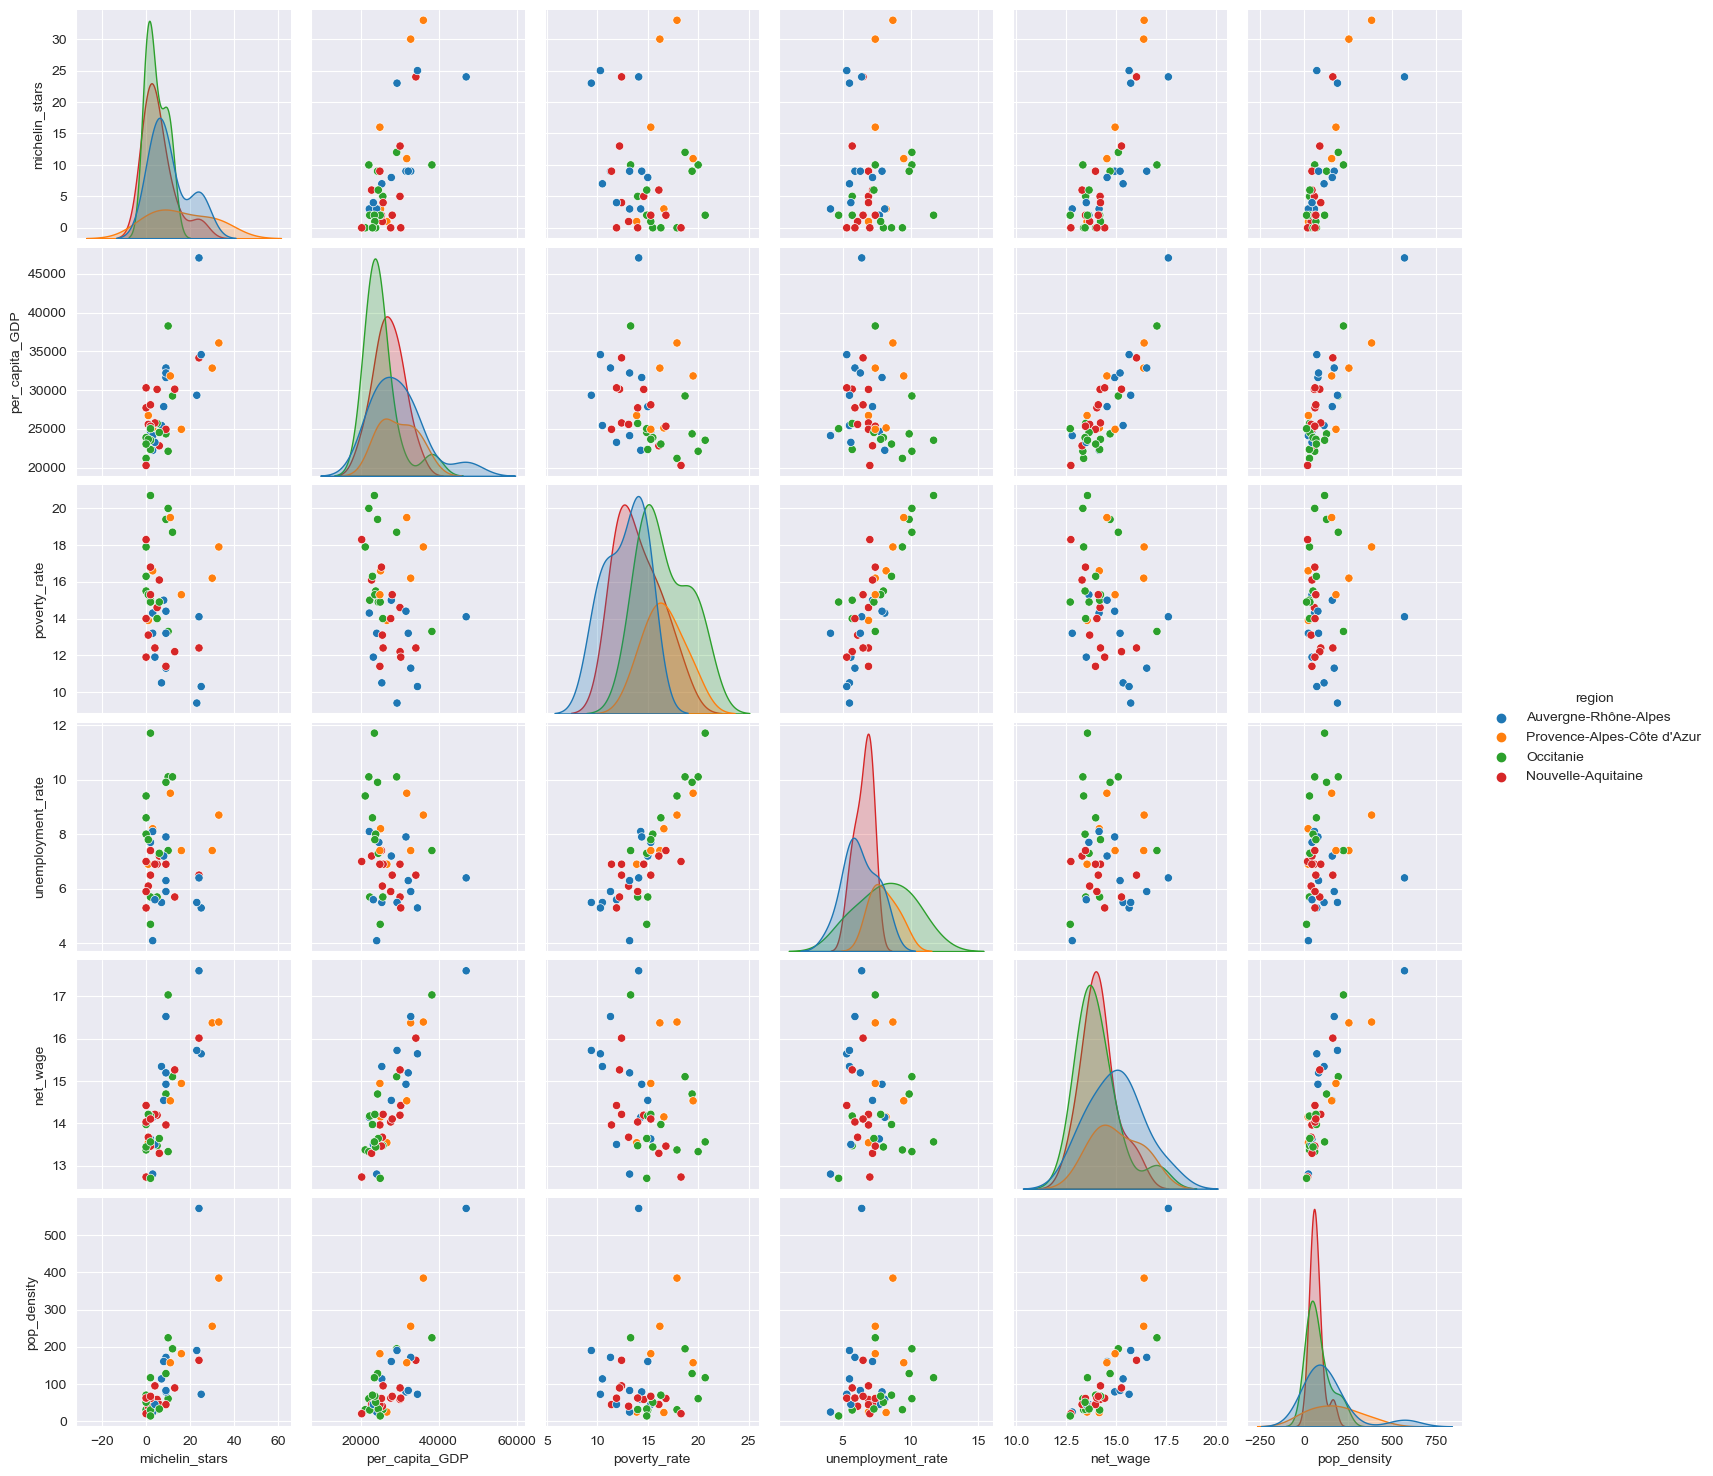

In [16]:
print(f"Departments: {south_dept.department.nunique()}")
sns.pairplot(south_dept, hue='region')

- *Auvergne-Rhône-Alpes* and *Provence-Alpes-Côte d'Azur* regions are prominently represented by five to six departments. These departments notably cluster towards the upper end in `michelin_stars` across most variable distributions. In contrast, departments from the *Occitanie* region tend to cluster towards the lower spectrum for `michelin_stars`
- *Occitanie* features prominently on the higher end of the `poverty_rate` and `unemployment_rate` scales. While these patterns are evident, pinpointing whether the same departments persistently appear in these clusters across all variables would require a closer examination.
- *Provence-Alpes-Côte d'Azur* and *Occitanie* stand out with the broadest spread in individual variable distributions, indicating a diverse range of values within these regions.

While these patterns provide valuable insights, a deeper validation at the departmental level is essential to confirm these preliminary findings.

We explore a pairplot at the *arrondissement* level. We are not in possession of `per_capita_GDP` or `unemployment_rate` data at this level of granularity

Arrondissements: 134


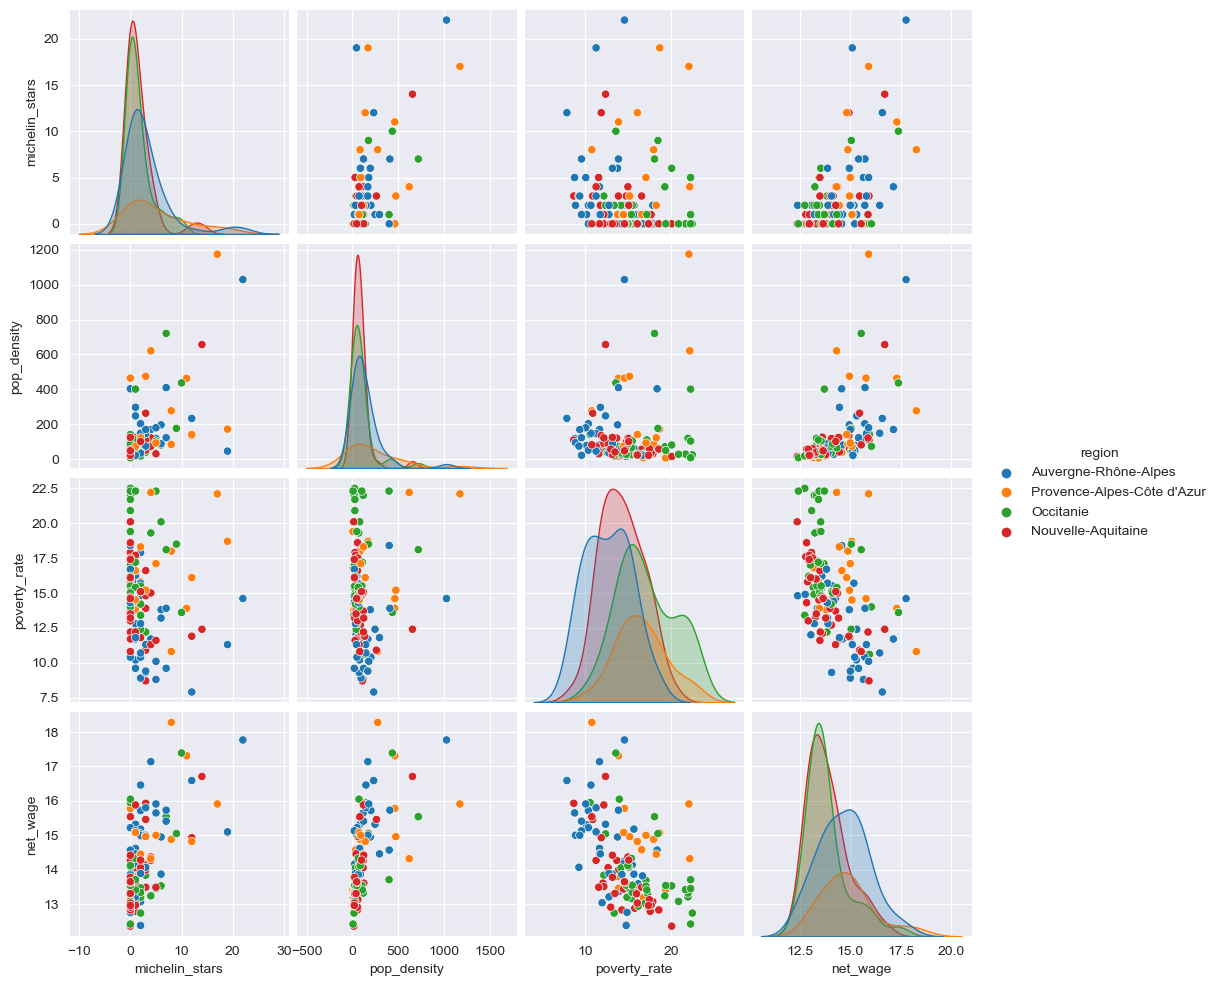

In [17]:
print(f"Arrondissements: {south_arron.arrondissement.nunique()}")
sns.pairplot(south_arron, hue='region')

There appears to be a bi-modal `poverty_rate` distribution for *Occitanie*. There are a number of arrondissements with a relatively high poverty rate.

----
&nbsp;
## Heatmaps

Visualising pairwise correlations above/below a certain threshold

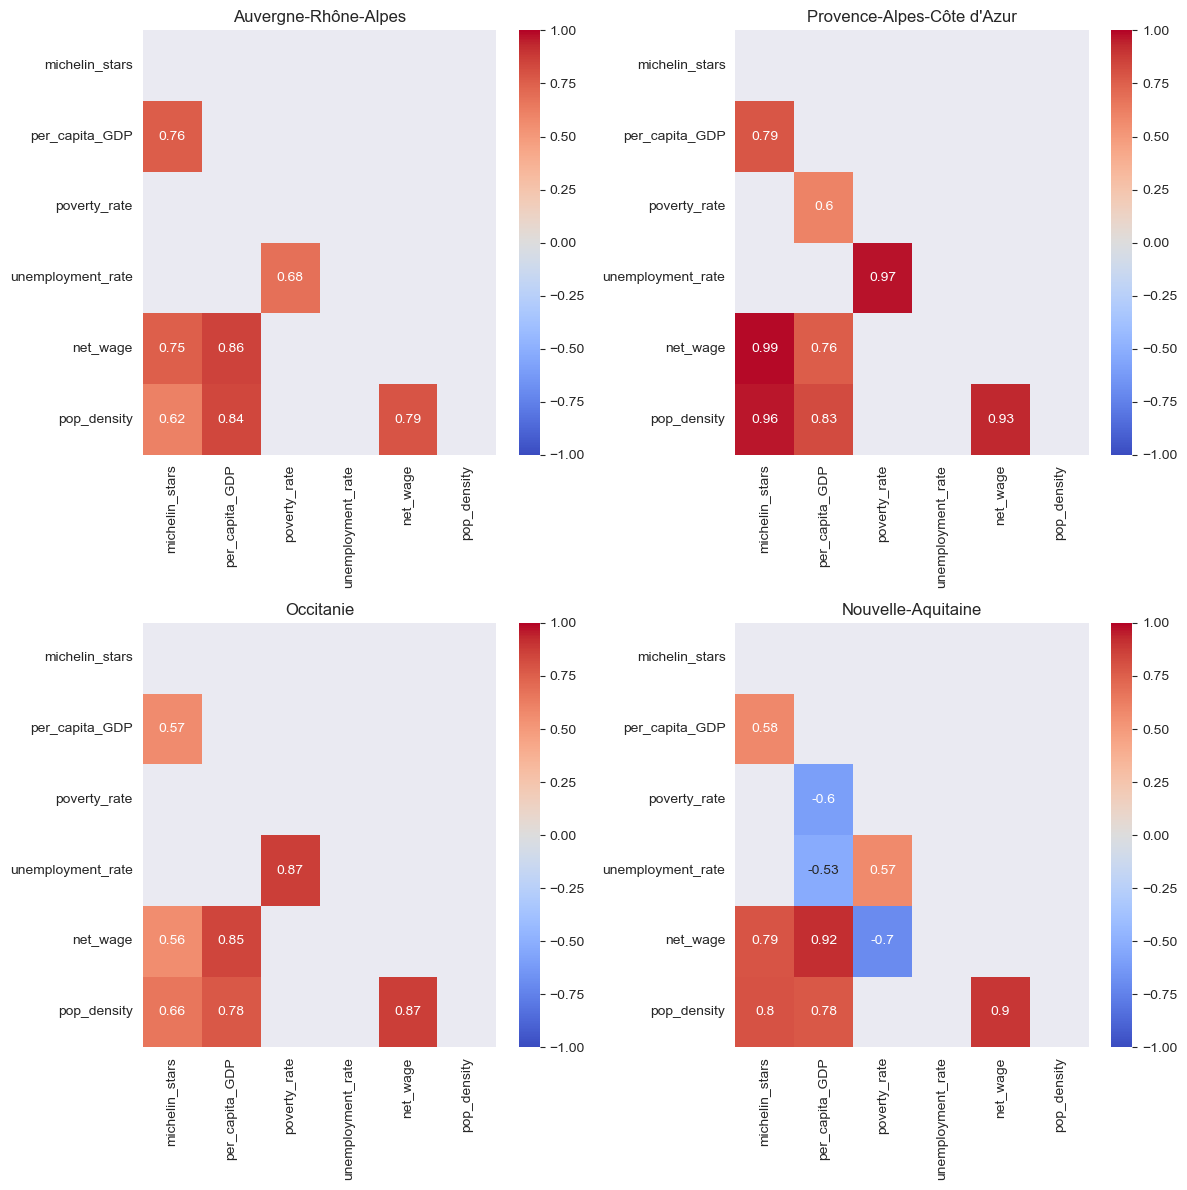

In [18]:
# We plot the correlation coefficients above a certain threshold
# I define my threshold for 'moderate correlation'
south_corr = plot_high_correlations(south_dept, level='regional', threshold=0.5)

Table of how we'll interpret Pearson's coefficient $r$ in the above heatmap
&nbsp;

| Range of $r$ | Absolute Value | Interpretation          |
|:------------:|:--------------:|:-----------------------:|
|  0.9 to 1.0  |   0.9 to 1.0   | Very Strong Correlation|
|  0.7 to 0.9  |   0.7 to 0.9   | Strong Correlation      |
|  0.5 to 0.7  |   0.5 to 0.7   | Moderate Correlation    |
|  0.3 to 0.5  |   0.3 to 0.5   | Weak Correlation        |
|  0.0 to 0.3  |   0.0 to 0.3   | Very Weak Correlation   |
|      0       |       0        | No Correlation          |

This analysis does not seek to prove anything and is exploratory in nature. It aims to reveal patterns, relationships, or anomalies that could form the basis of further investigations. 

#### *Provence-Alpes-Côte d'Azur*
- There's a moderate positive correlation between `per_capita_GDP` | `poverty_rate` which could suggest economic inequality. There are cities in this region known for luxury and tourism which can create pockets of high GDP alongside areas of poverty. 
- `unemployment_rate` | `poverty_rate` are strongly correlated which is an expected relationship.
- The high correlation between `michelin_stars` | `net_wage` (0.989997) is intriguing. Does a higher concentration of Michelin-starred restaurants influence the average net wage, or is it the other way around, where areas with higher net wages attract more high-end dining establishments?

#### *Occitanie*
- `unemployment_rate` | `poverty_rate` are strongly correlated along with `net_wage` | `per_capita_GDP`.
- the strong positive correlation between `net_wage` | `pop_density` (0.868679) suggests that areas with higher population density might offer better wage opportunities. This is an expected observation, as dense areas often have cities or business hubs.

#### *Nouvelle-Aquitaine*

- There's a moderate negative correlation between 
    - `per_capita_GDP` | `poverty_rate`,
    - `per_capita_GDP` | `unemployment_rate`
    - `net_wage` | `poverty_rate` 
which are all typical yet essential economic health pointers.
  
- `net_wage` | `per_capita_GDP` show a strong positive correlation which could hint at a more even distribution of income or a balanced economy where high GDP doesn't necessarily mean just a few pockets of wealth.


----
&nbsp;
### We investigate `michelin_stars`, `per_capita_GDP`, `poverty_rate`, `unemployment_rate` & `net_wage`  at the departmental level across regions.

In [19]:
cols_of_interest = ['michelin_stars', 'per_capita_GDP', 'poverty_rate', 'unemployment_rate', 'net_wage']

The following tables provide statistical summaries of various socio-economic factors for the different regions of Southern France. These statistics give us insights into the region's overall economic health and the standard of living.

In [20]:
overview = south_dept.groupby('region')[cols_of_interest].describe()
print_overview_stats(overview)

Region: Auvergne-Rhône-Alpes
----------------------------
Statistic | Michelin_stars | Per_capita_gdp | Poverty_rate | Unemployment_rate | Net_wage
-----------------------------------------------------------------------------------------
Count     | 12.00          | 12.00          | 12.00        | 12.00             | 12.00   
Mean      | 10.50          | 29595.04       | 12.74        | 6.29              | 14.96   
Std       | 8.53           | 6876.40        | 2.00         | 1.22              | 1.35    
Min       | 2.00           | 22224.31       | 9.40         | 4.10              | 12.80   
25%       | 3.75           | 24529.08       | 11.10        | 5.50              | 14.01   
50%       | 8.50           | 28593.16       | 13.20        | 6.10              | 15.05   
75%       | 12.50          | 32361.43       | 14.33        | 7.33              | 15.66   
Max       | 25.00          | 47048.24       | 15.30        | 8.10              | 17.60   
Region: Nouvelle-Aquitaine
---------------

##### Key Insights: 

**Auvergne-Rhône-Alpes**
Has the highest `per_capita_GDP` value at 47048.24 € but shows the greatest standard deviation showing there is a large range of values for this metric. The `unemployment_rate` and `poverty_rate` are the lowest in the South of France

**Nouvelle-Aquitaine** 
`per_capita_GDP` is lower than Auvergne-Rhône-Alpes but the net wage seems comparable. The mean `poverty_rate` is marginally higher.

**Occitanie**
Has the highest `unemployment_rate`, which aligns with its high `poverty_rate`. Its `per_capita_GDP` rate is the lowest of the regions, along with its Michelin presence.

**Provence-Alpes-Côte d'Azur** This region has the most Michelin stars on average but has fewer departments. The `unemployment` and `poverty` rates are considerable, even with a high mean GDP, suggesting some level of economic disparity.

#### Visualising the distribution of the above data

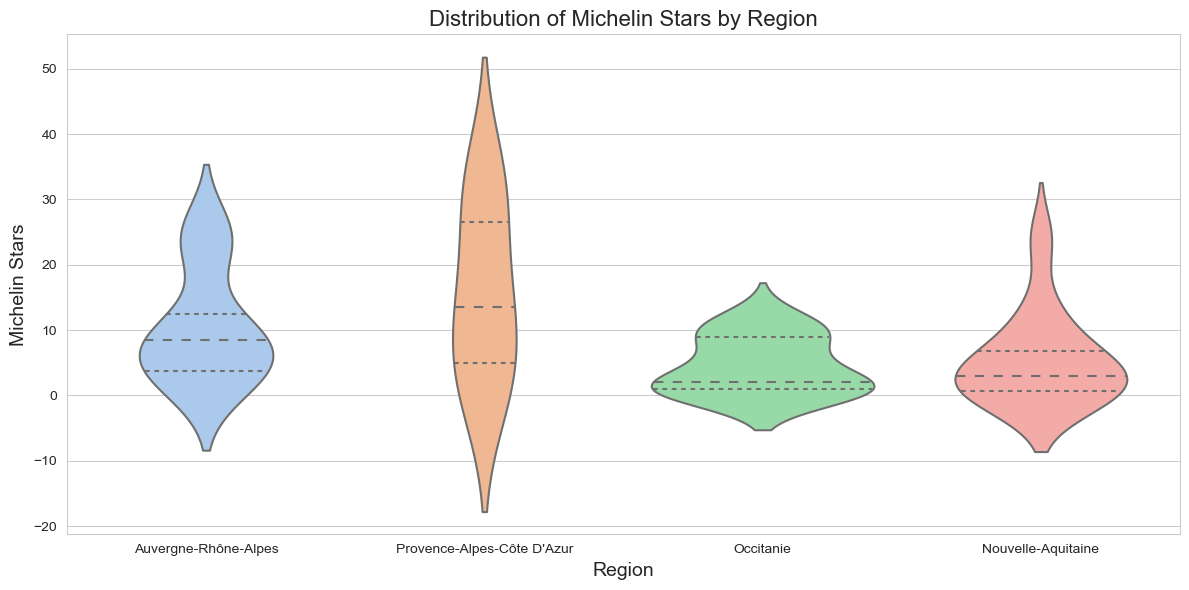

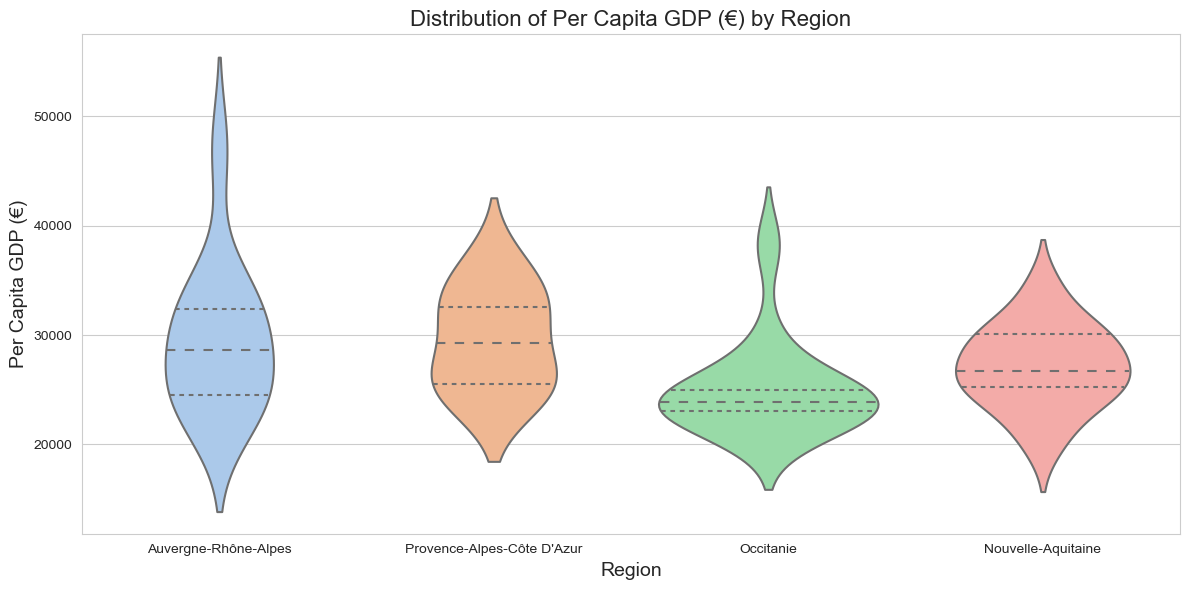

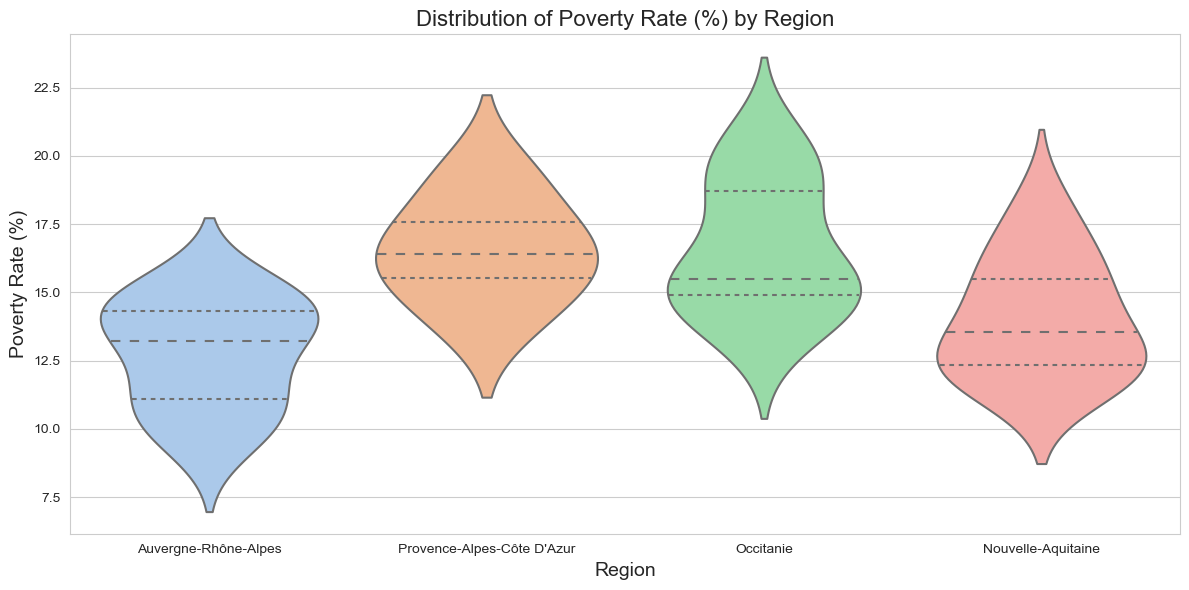

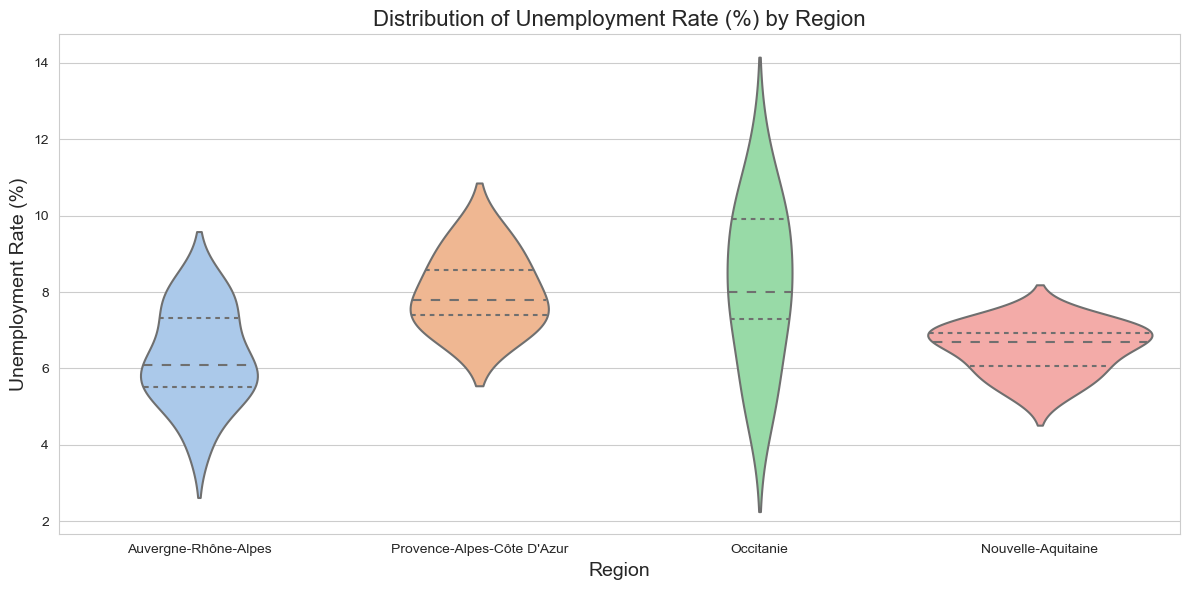

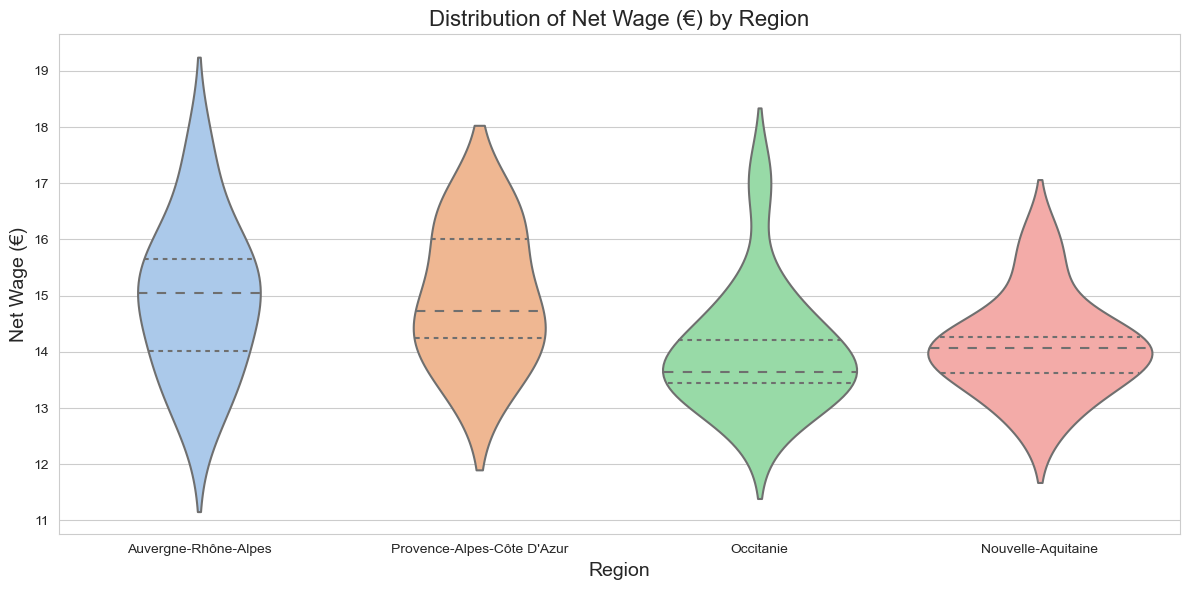

In [21]:
plot_violinplots(south_dept, cols_of_interest)

**Violin Plots**:

Offer a visualization of the distribution of the data, its probability density, and its cumulative distribution. 

Key features:

- The width of the plot at different values indicates the density of the data at that value, with wider sections representing higher densities (more data points).

- Dashed lines inside the violin indicate key statistics of the data. Typically, the top and bottom of the dashed lines represent the interquartile range (the 25th and 75th percentiles), while the line's center can be the median (50th percentile).

These plots highlight not just central tendency and spread (as with box plots), but also show data density and potential multimodal distributions.

We notice Occitanie has a bi-modal distribution for `per_capita_GDP` and `poverty_rate`. Are the same departments represented? Occitanie also shows a large range of `unemployment_rate` values.

----
&nbsp;
#### `find_extreme_departments` 
This function identifies which departments stand out as the highest and lowest performers for various socio-economic indicators.

In [22]:
find_extreme_departments(south_dept, cols_of_interest)

Region: Auvergne-Rhône-Alpes

michelin_stars
	Max: Savoie (73) = 25 
	Min: Allier (03) = 2 

per_capita_GDP
	Max: Rhône (69) = 47048.24 €
	Min: Ardèche (07) = 22224.31 €

poverty_rate
	Max: Allier (03) = 15.3 %
	Min: Haute-Savoie (74) = 9.4 %

unemployment_rate
	Max: Ardèche (07) = 8.1 %
	Min: Cantal (15) = 4.1 %

net_wage
	Max: Rhône (69) = 17.6 €
	Min: Cantal (15) = 12.8 €

--------------------------------------------------
Region: Provence-Alpes-Côte d'Azur

michelin_stars
	Max: Bouches-du-Rhône (13) = 33 
	Min: Hautes-Alpes (05) = 1 

per_capita_GDP
	Max: Bouches-du-Rhône (13) = 36072.35 €
	Min: Var (83) = 24932.52 €

poverty_rate
	Max: Vaucluse (84) = 19.5 %
	Min: Hautes-Alpes (05) = 13.9 %

unemployment_rate
	Max: Vaucluse (84) = 9.5 %
	Min: Hautes-Alpes (05) = 6.9 %

net_wage
	Max: Bouches-du-Rhône (13) = 16.39 €
	Min: Hautes-Alpes (05) = 13.54 €

--------------------------------------------------
Region: Occitanie

michelin_stars
	Max: Hérault (34) = 12 
	Min: Ariège (09) = 0 


## Insights from the Output:

**Michelin Stars:**

- Auvergne-Rhône-Alpes: Savoie (73) stands out with 25 Michelin stars, indicating a potential culinary tourism hotspot, whereas Allier (03) has just 2.
- Provence-Alpes-Côte d'Azur (PACA):, Bouches-du-Rhône (13) leads with 33 stars, while Hautes-Alpes (05) has only 1.
- Occitanie: Hérault (34) leads with 12 stars. Ariège (09) has none.

**Economic Indicators:**

- In each region, the maximum `per_capita_GDP` and `net_wage` is from a department with a large city/metropole

| Region                     | Department             | City/Metropole | Largest Cities | `per_capita_GDP` (€) | `net_wage` (€) |
|----------------------------|------------------------|----------------|----------------|----------------------|----------------|
| Auvergne-Rhône-Alpes       | Rhône (69)             | Lyon           | 3rd            | 47048.24             | 17.60          |
| Nouvelle-Aquitaine         | Gironde (33)           | Bordeaux       | 9th            | 34152.66             | 16.01          |
| Occitanie                  | Haute-Garonne (31)     | Toulouse       | 4th            | 38265.18             | 17.03          |
| Provence-Alpes-Côte d'Azur | Bouches-du-Rhône (13)  | Marseille      | 2nd            | 36072.35             | 16.39          |


The above results show urban areas have more economic opportunities and higher average incomes. This could be attributed to a concentration of businesses, higher education institutions, and other factors that drive economic growth.

When ranking by size, we consider the city itself rather than the *métropole*/conurbation. For example, Lyon métropole is larger than Marseille métropole.


**Social Indicators:**

- Occitanie: Pyrénées-Orientales (66) has the highest `poverty_rate` and `unemployment_rate` in the South of France at 20.7% and 11.7% respectively. 
- PACA: Vaucluse (84) has the greatest `poverty_rate` and `unemployment_rate` at 19.5% and 9.5% respectively.

(66) & (84) are departments that show signs of economic distress.


To better understand these results, we find the weighted mean `per_capita_GDP`, `poverty_rate`, `unemployment_rate` and `net_wage` across France
$$
\mathrm{Weighted \ Mean} = \frac{\sum_i (\mathrm{value}_i \times \mathrm{weight}_i)}{\sum_i \mathrm{weight}_i}
$$

Paris is a significant outlier in the context of France's GDP. As the capital city, is not only the political center but also the economic and cultural hub. It houses many multinational corporations, leading institutions, and is a global city. Including Paris might make the weighted average GDP unrepresentative of the entire country due to its unique economic landscape.

In [23]:
paris = filter_dataframe(departments, departments='Paris')
print(f"GDP Paris: {paris['per_capita_GDP'].values[0]} €")

GDP Paris: 105320.08 €


In [24]:
no_paris = filter_dataframe(departments, exclude_departments='Paris')

# Exclude Paris from GDP calculation
france_GDP_no_paris = (no_paris['per_capita_GDP'] * no_paris['municipal_population']).sum() /\
                        no_paris['municipal_population'].sum()

france_GDP = (departments['per_capita_GDP'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

print(f"Weighted mean GDP per capita across France (excluding Paris): {france_GDP_no_paris:.2f}€")
print(f"Weighted mean GDP per capita across France: {france_GDP:.2f}€\n")

Weighted mean GDP per capita across France (excluding Paris): 32308.02€
Weighted mean GDP per capita across France: 34708.49€


There is approx. 7.5% increase in the weighted average `per_capita_GDP` including Paris in the calculation. This could be significant. 

In [25]:
# Weighted mean GDP per capita - South of France
south = filter_dataframe(departments, regions=['provence', 'rhone alpes', 'occitanie', 'aquitaine'])
south_GDP = (south['per_capita_GDP'] * south['municipal_population']).sum() /\
                        south['municipal_population'].sum()
print(f"Weighted mean GDP per capita South of France: {south_GDP:.2f}€\n")

Weighted mean GDP per capita South of France: 30830.39€


**GDP per Capita as an Economic Marker**:
- Advantage: 
    - Provides a quick snapshot of an economy's health
- Limitations:
    - Doesn't account for income distribution
    - Doesn't consider informal economy
    - May not reflect actual standards of living

In [26]:
# Compute the weighted means
france_poverty = (departments['poverty_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_unemployment = (departments['unemployment_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_wage = (departments['net_wage'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()


print(f"Weighted mean poverty rate across France: {france_poverty:.2f}%")
print(f"Weighted mean unemployment rate across France: {france_unemployment:.2f}%")
print(f"Weighted mean hourly wage across France: {france_wage:.2f}€")

Weighted mean poverty rate across France: 14.43%
Weighted mean unemployment rate across France: 7.13%
Weighted mean hourly wage across France: 16.05€


- **Hourly wage**: Reflects the earning potential and can provide insights into the dominant industries or sectors in a region

- **Poverty rate**: A high value can indicate economic distress, signaling potential issues like lack of job opportunities, low wages, or other socio-economic challenges.

- **Unemployment rate**: Directly shows the health of the job market. Elevated values can be a symptom of economic issues, structural challenges, or a mismatch between available jobs and the skills of the workforce.

Reexamining the departmental extrema, we notice *Pyrénées-Orientales* (66) in Occitanie and *Vaucluse* (84) in PACA have a `poverty_rate` and `unemployment_rate` **well above** the national average.

#### Visualisation of these metrics across the southern regions and across all France

In [27]:
cols_of_interest = ['per_capita_GDP', 'unemployment_rate', 'poverty_rate', 'net_wage']
titles = ['GDP per capita (€)', 'Unemployment Rate (%)', 'Poverty Rate (%)', 'Hourly Net Wage (€)']

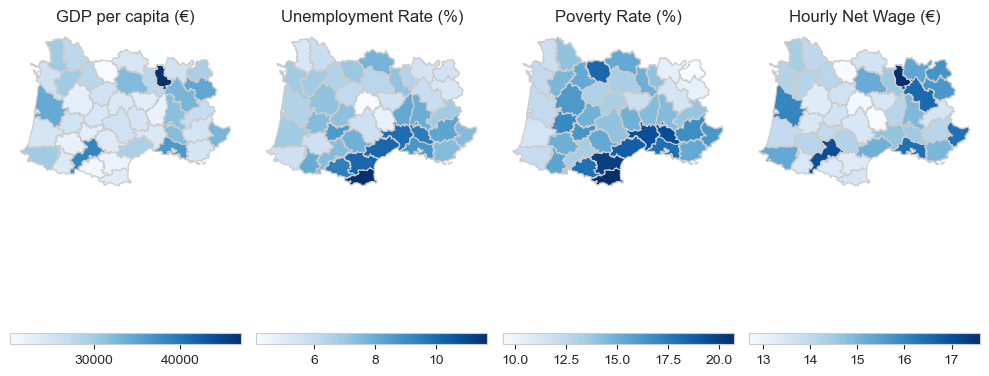

In [28]:
plot_multi_choropleth(south_dept, cols_of_interest, titles, granularity='department', show_labels=False)

Rhône (69) (with capital Lyon) has the greatest `per_capita_GDP` in the South, a relatively low `poverty_rate` & `unemployment_rate` and a relatively high `net_wage`. By these metrics, this is one of the wealthiest departments in South of France.

The departments along the Mediterranean coast (excluding 06 and 83) are some of the most poverty-stricken in the South of France.

As shown below, these departments have some of the highest `unemployment_rate` and `poverty_rate` in the whole of France.

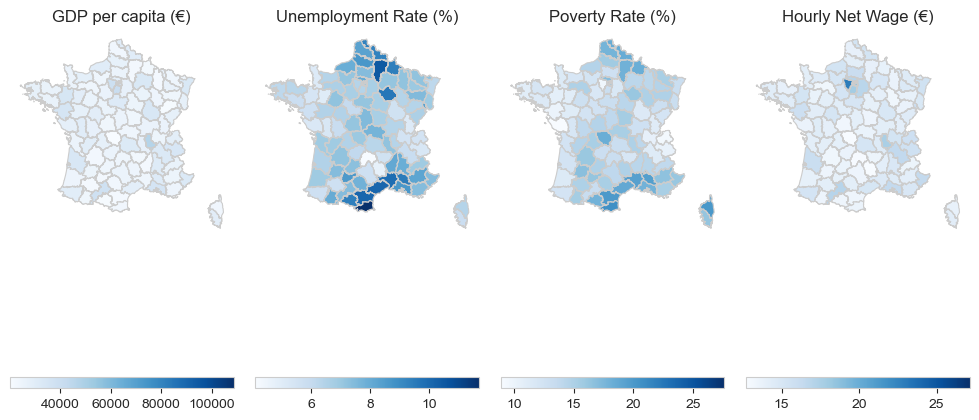

In [29]:
plot_multi_choropleth(dept_short, cols_of_interest, titles, granularity='department', show_labels=False)

----
&nbsp;
## Regional gastronomy & Michelin starred restaurants
Exploring the top 10 departments in the South of France by total Michelin stars as opposed to Michelin starred restaurants.

In [30]:
south_all_cols = filter_dataframe(departments, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
top_geo_restaurants(south_all_cols, granularity='department', top_n=10)

Top 10 departments with most Michelin-starred restaurants:


1: Department: Bouches-du-Rhône
Total Stars: 33
Total Restaurants: 25
4 ⭐⭐⭐ Restaurants
21 ⭐ Restaurants


2: Department: Alpes-Maritimes
Total Stars: 30
Total Restaurants: 24
1 ⭐⭐⭐ Restaurant
4 ⭐⭐ Restaurants
19 ⭐ Restaurants


3: Department: Savoie
Total Stars: 25
Total Restaurants: 17
2 ⭐⭐⭐ Restaurants
4 ⭐⭐ Restaurants
11 ⭐ Restaurants


4: Department: Gironde
Total Stars: 24
Total Restaurants: 19
5 ⭐⭐ Restaurants
14 ⭐ Restaurants


5: Department: Rhône
Total Stars: 24
Total Restaurants: 20
4 ⭐⭐ Restaurants
16 ⭐ Restaurants


6: Department: Haute-Savoie
Total Stars: 23
Total Restaurants: 16
2 ⭐⭐⭐ Restaurants
3 ⭐⭐ Restaurants
11 ⭐ Restaurants


7: Department: Var
Total Stars: 16
Total Restaurants: 13
1 ⭐⭐⭐ Restaurant
1 ⭐⭐ Restaurant
11 ⭐ Restaurants


8: Department: Pyrénées-Atlantiques
Total Stars: 13
Total Restaurants: 13
13 ⭐ Restaurants


9: Department: Hérault
Total Stars: 12
Total Restaurants: 12
12 ⭐ Restaurants


10

### Economic Disparity and Gastronomy:

**Luxury Tourism and Affluence**:

- **Alpes-Maritimes (06) and Var (83)**: 
    These departments anchor the luxurious Côte d'Azur. With cities like Cannes, Antibes, Nice, and Saint-Tropez, they allure the global elite due to film festivals, yachting events, and the Riviera's glamorous appeal. The influx of high-net-worth tourists drives demand for upscale dining, leading to a surge in Michelin-starred restaurants.

- **Savoie (73) and Haute-Savoie (74)**: 
    Renowned for ski resorts like Chamonix and Courchevel, their global standing and wealthy clientele account for the prevalence of Michelin-starred establishments.

**Contrasting Economic Realities**:

- **Hérault (34), Vaucluse (84), and Bouches-du-Rhône (13)**: 
    These departments, despite their Michelin recognition, face significant economic challenges.

**Tourism as a Double-Edged Sword**:
&nbsp;
Tourism can lead to economic imbalances. While certain segments (e.g., luxury hospitality) thrive, the wealth may not be evenly distributed. Tourist-centric locales might have prospering hotels and restaurants but still endure stark economic contrasts. This dynamic might elucidate the Michelin recognitions in Hérault and Vaucluse, highlighting the uneven boons of tourism.

**Conclusion**:

The juxtaposition of Michelin stars and economic disparity paints a complex portrait of the South of France. While culinary excellence can be a beacon of cultural pride and economic gain for some, it can exist concurrently with profound socioeconomic challenges


We plot the South of France by number of ⭐⭐ and ⭐⭐⭐ restaurants

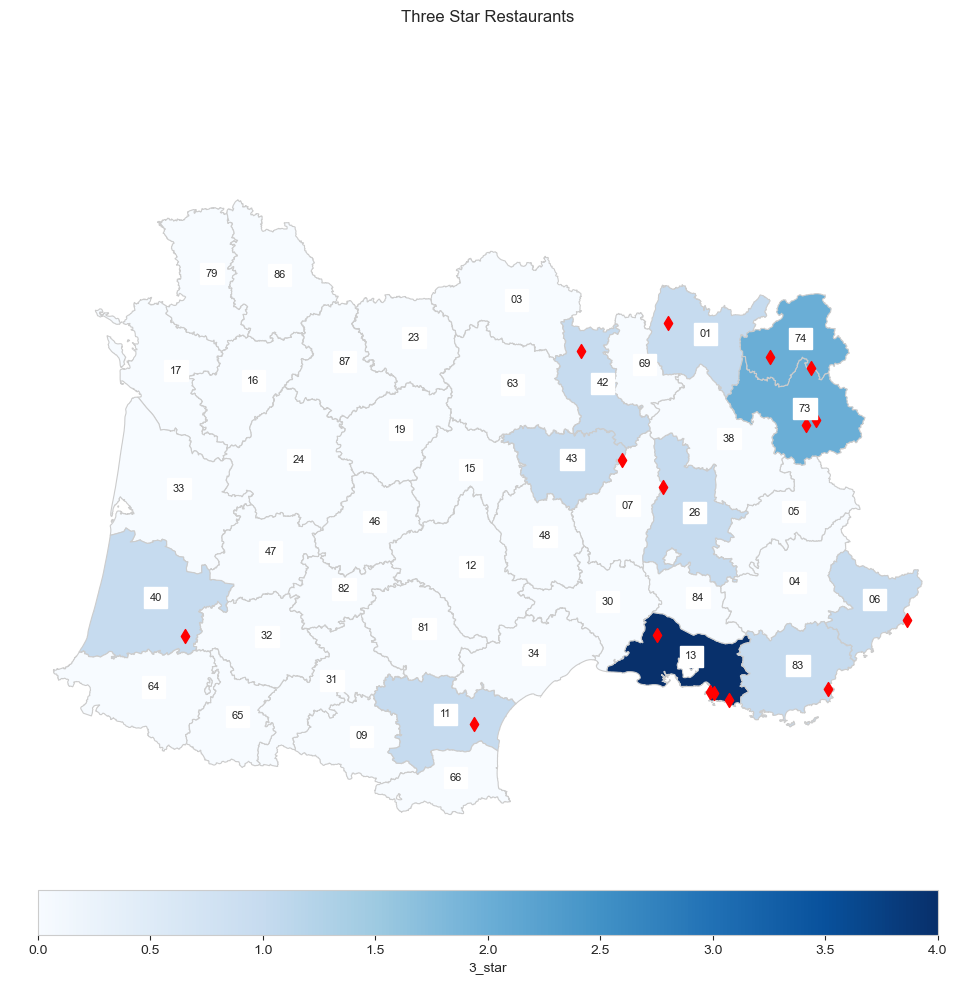

In [31]:
plot_choropleth(south_all_cols, '3_star', 'Three Star Restaurants', restaurants=True, star_rating=3, show_legend=False)

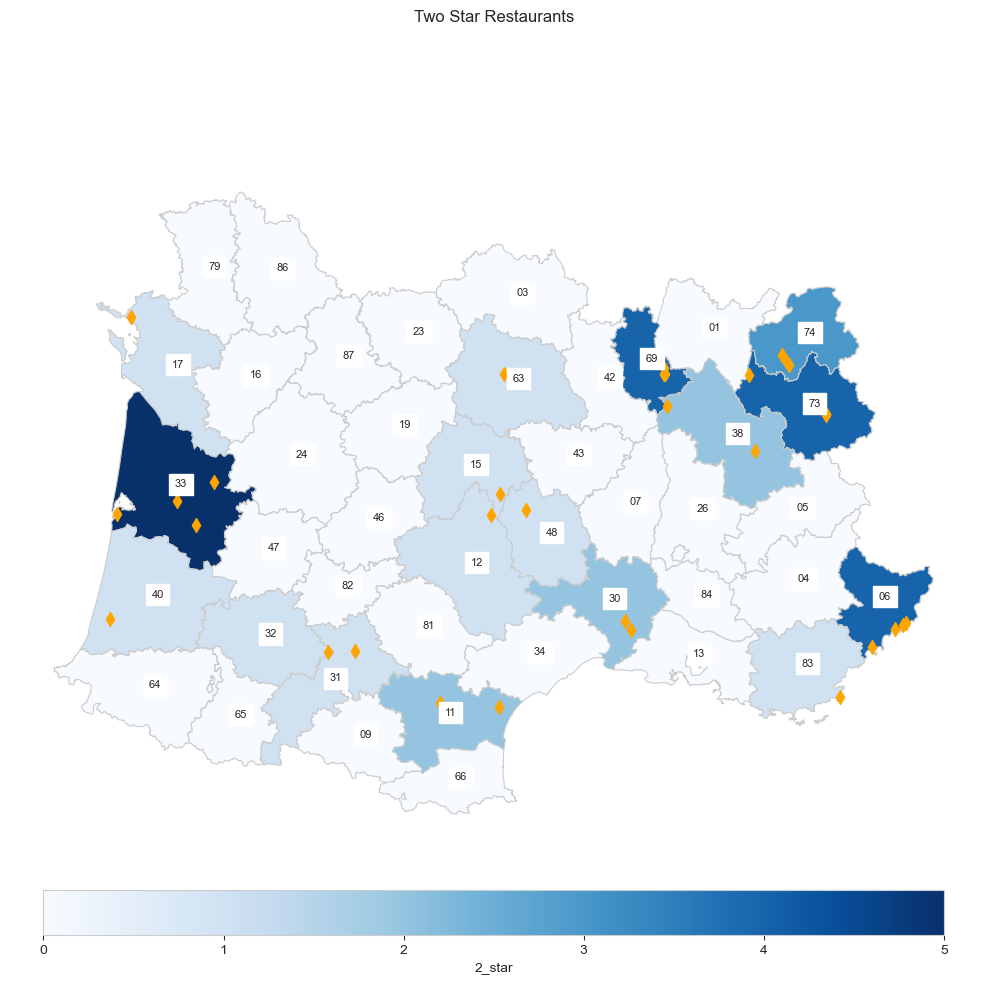

In [32]:
plot_choropleth(south_all_cols, '2_star', 'Two Star Restaurants', restaurants=True, star_rating=2, show_legend=False)

### Price

The Michelin Guide defines its restaurant price ratings in the following way;
&nbsp;

| Price Category   | Description          |
|------------------|----------------------|
| €€€€             | Spare no expense     |
| €€€              | Special occasion     |
| €€               | A moderate spend     |
| €                | On a budget          |

&nbsp;
How many starred restaurants in the South of France have a price rating below €€€?

In [33]:
france_restos = pd.read_csv("../../data/France/all_restaurants(arrondissements).csv")
south_restos = filter_dataframe(france_restos, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
print(f"South of France:\n{south_restos.shape[0]} restaurants in total (including Bibs)")

South of France:
486 restaurants in total (including Bibs)


In [34]:
# Filter out bib gourmands
starred_restos = south_restos[south_restos['stars'] != 0.5]

# Group by price rating
price_groups = starred_restos.groupby('price').size()
print(price_groups)

price
€€        3
€€€     112
€€€€    163
dtype: int64


Only three Michelin starred restaurants have a price rating of €€: "A moderate spend" which is also the Michelin definition of the 'Bib Gourmand' award where diners can expect to pay no more than 40€ for a three-course meal.

While the Michelin Guide offers a general price rating (from 'On a budget' to 'Spare no expense'), these descriptors can be subjective and may vary significantly based on an individual's perspective or the restaurants location and popularity.

To offer a more tangible insight into the price of a meal, we will select five restaurants at random in the €€€ and €€€€ category. A random seed is selected making the selection reproducible.

If available, the price reported will be a tasting menu for dinner (without drinks). If the restaurant doesn't offer a tasting menu, we report the price of a three-course menu or the price of three-courses à la carte

In [35]:
selected_restos = get_random_restaurants(south_restos, seed=45)
display_restaurants(selected_restos)

Price rating: €€€€




Price rating: €€€


#### Results

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Lalique | Bommes, 33210 | ⭐⭐ | 245 €                 |
| La Vague d'Or - Cheval Blanc St-Tropez | Saint-Tropez, 83990 | ⭐⭐⭐ | 450 €                 |
| Le Saint-Estève | Le Tholonet, 13100 | ⭐ | 190 €                 |
| Ursus | Tignes, 73320 | ⭐ | 168 €                 |
| La Table de Patrick Raingeard | Èze-Bord-de-Mer, 06360 | ⭐ | 250 €                 |

**Price rating: €€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Restaurant de la Loire | Pouilly-sous-Charlieu, 42720 | ⭐ | 92 €                  |
| Le Passe Temps | Lyon, 69006 | ⭐ | 105 €                 |
| Les Clefs d'Argent | Mont-de-Marsan, 40000 | ⭐ | 97 €                  |
| Auberge du Cep | Fleurie, 69820 | ⭐ | 70 €                  |
| Villa de l'Étang Blanc | Seignosse, 40510 | ⭐ | 90 €                  |


There's one three star restaurant in the random selection and the price difference is vast!

Considering the ⭐⭐ restaurant *Lalique* (33), there is not a vast difference in price between the ⭐ restaurants in the €€€€ price category.
 
We randomly select ⭐⭐ & ⭐⭐⭐ restaurants below to get some idea of the price spread. 

In [36]:
three_stars = get_random_restaurants(south_restos, star_rating=3, seed=45)
display_restaurants(three_stars)

Price rating: €€€€


#### Three-Star Michelin Restaurants

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| L'Oustau de Baumanière | Les Baux-de-Provence, 13520 | ⭐⭐⭐ | 330 €                 |
| Le 1947 à Cheval Blanc | Courchevel, 73120 | ⭐⭐⭐ | 415 €                 |
| La Villa Madie | Cassis, 13260 | ⭐⭐⭐ | 350 €                 |
| Auberge du Vieux Puits | Fontjoncouse, 11360 | ⭐⭐⭐ | 290 €                 |
| Pic | Valence, 26000 | ⭐⭐⭐ | 380 €                 |


In [37]:
two_stars = get_random_restaurants(south_restos, star_rating=2, seed=45)
display_restaurants(two_stars)

Price rating: €€€€


#### Two-Star Michelin Restaurants

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Le Pressoir d'Argent - Gordon Ramsay | Bordeaux, 33000 | ⭐⭐ | 235 €                 |
| La Pyramide - Patrick Henriroux | Vienne, 38200 | ⭐⭐ | 206 €                 |
| La Table Lionel Giraud | Narbonne, 11100 | ⭐⭐ | 220 €                 |
| Le Neuvième Art | Lyon, 69006 | ⭐⭐ | 220 €                 |
| La Table de Franck Putelat | Carcassonne, 11000 | ⭐⭐ | 235 €                 |


Given the price range of our random selection of ⭐⭐⭐ and ⭐⭐ Michelin restaurants, we can draw several insights:

**Price Tier Distinction**: 
All of the restaurants listed, whether they have three stars or two, fall under the €€€€ price rating, reinforcing the notion that Michelin-starred dining is often an upscale experience. This could be expected given the high standards and the associated costs of maintaining such a status.

**Three Stars vs. Two Stars**: 
The price range for the three-star restaurants is broader, ranging from 290 € to 450 € for a tasting menu. This could be attributed to the uniqueness of each restaurant's offerings and perhaps the location, expertise of the chef, and the quality of the ingredients used. On the other hand, two-star restaurants have a more narrow price range (206 € to 235 €), suggesting some consistency in pricing in this category.

**Location**: 
Locations like Courchevel and Saint-Tropez are known to be luxurious destinations, which could play a role in the pricing. The presence of Michelin-starred restaurants in these areas may reflect the high spending capacity of the clientele frequenting these regions.
We randomly selected two restaurants of the *Cheval Blanc* group (In France, there is a third in Paris). Both these restaurants break the 400€ mark.

**The Two-Star Conundrum**: 
Two-star restaurants often have chefs and teams that are pushing boundaries, aiming for that elusive third star. This drive can result in innovative menus and exceptional quality, potentially offering diners a near three-star experience at slightly reduced prices.

In 2018 I visited  ⭐⭐ [*Mirazur*](https://www.mirazur.fr) in Menton (06), the tasting menu was 250€. In 2019, it was awarded  ⭐⭐⭐ and was number 1 in the [World's 50 best restaurants](https://www.theworlds50best.com/previous-list/2019), the tasting menu is currently 450€.

----
&nbsp;
## Narrowing scope to *Provence-Alpes-Côte d'Azur* & *Occitanie*

#### Reasons for increased focus

**Diversity of Indicators:** 
Both Regions show a wide variation in metrics across their departments. This suggests potential opportunities and challenges within these regions

**Economic & Social Significance:** 
Both regions have departments that stand out either due to their economic potential (like Bouches-du-Rhône in PACA and Haute-Garonne in Occitanie) or due to socio-economic challenges (like the high `poverty_rate` and `unemployment_rate` in Pyrénées-Orientales and Vaucluse).

**Unique Attributes:** 
The Michelin star count for PACA, suggests culinary significance, potential tourism angle and a wealth gap.

----
&nbsp;
# *Provence-Alpes-Côte d'Azur*

In [38]:
paca_dept = filter_dataframe(departments, regions='Provence')
paca_arron = filter_dataframe(arrondissements, regions='Provence')

### Choropleth Maps

Visualising the spread of `michelin_stars` and `pop_density` and department and arrondissement level

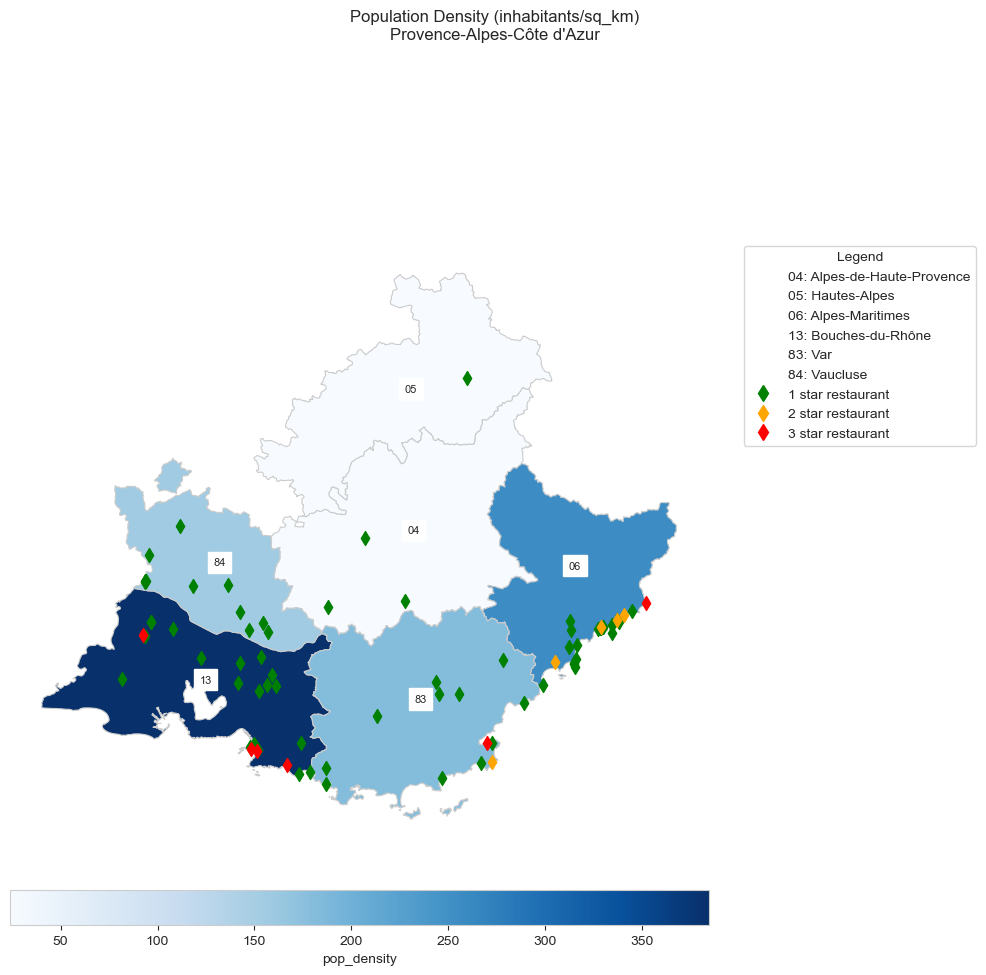

In [39]:
plot_choropleth(paca_dept, 'pop_density', 'Population Density (inhabitants/sq_km)', restaurants=True)

The two most densely populated departments are Alpes-Maritimes (06) and Bouches-du-Rhône (13). 

At arrondissement level, Marseille is by far the most densely populated in (13) whereas in (06), Grasse is more densely populated than Nice.

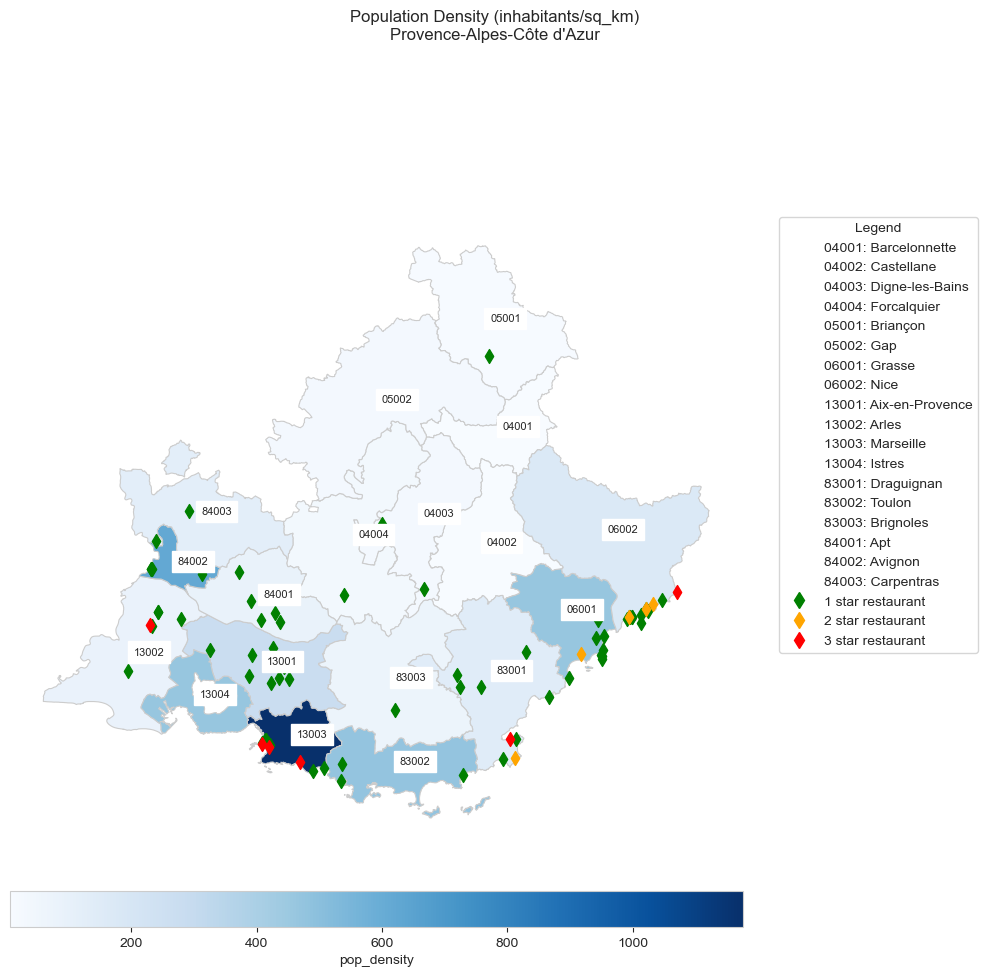

In [40]:
plot_choropleth(paca_arron, 'pop_density', 'Population Density (inhabitants/sq_km)',
                granularity='arrondissement', restaurants=True)

In [41]:
# We redefine our columns of interest. 
cols_of_interest = ['per_capita_GDP', 'unemployment_rate', 'poverty_rate', 'net_wage']
titles = ['GDP per capita (€)', 'Unemployment Rate (%)', 'Poverty Rate (%)', 'Hourly Net Wage (€)']
french_means = {'GDP': france_GDP,
                'poverty': france_poverty,
                'unemployment': france_unemployment,
                'wage': france_wage}

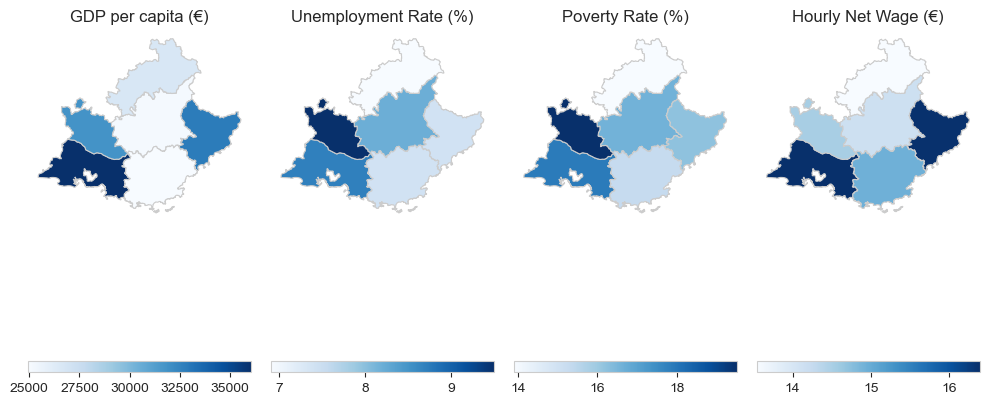

In [42]:
plot_multi_choropleth(paca_dept, cols_of_interest, titles, show_labels=False)

- Bouches-du-Rhône (13) and Vaucluse (84) have the highest `poverty_rate` and `unemployment_rate`. 

- Bouches-du-Rhône (13) and Alpes-Maritimes (06) have the highest `per_capita_GDP`

- Alpes-de-Haute-Provence (04) has the lowest `GDP_per_capita`, second lowest `net_wage` and moderately high `unemployment_rate` & `poverty_rate`

We have seen a moderate positive correlation between `per_capita_GDP` | `poverty_rate` in the PACA region. Unfortunately we cannot explore the spread of this relationship at *arrondissement* level. Data for `GDP_per_capita` & `unemployment_rate` have not been acquired at this level.

How do the above metrics compare with the French mean values?

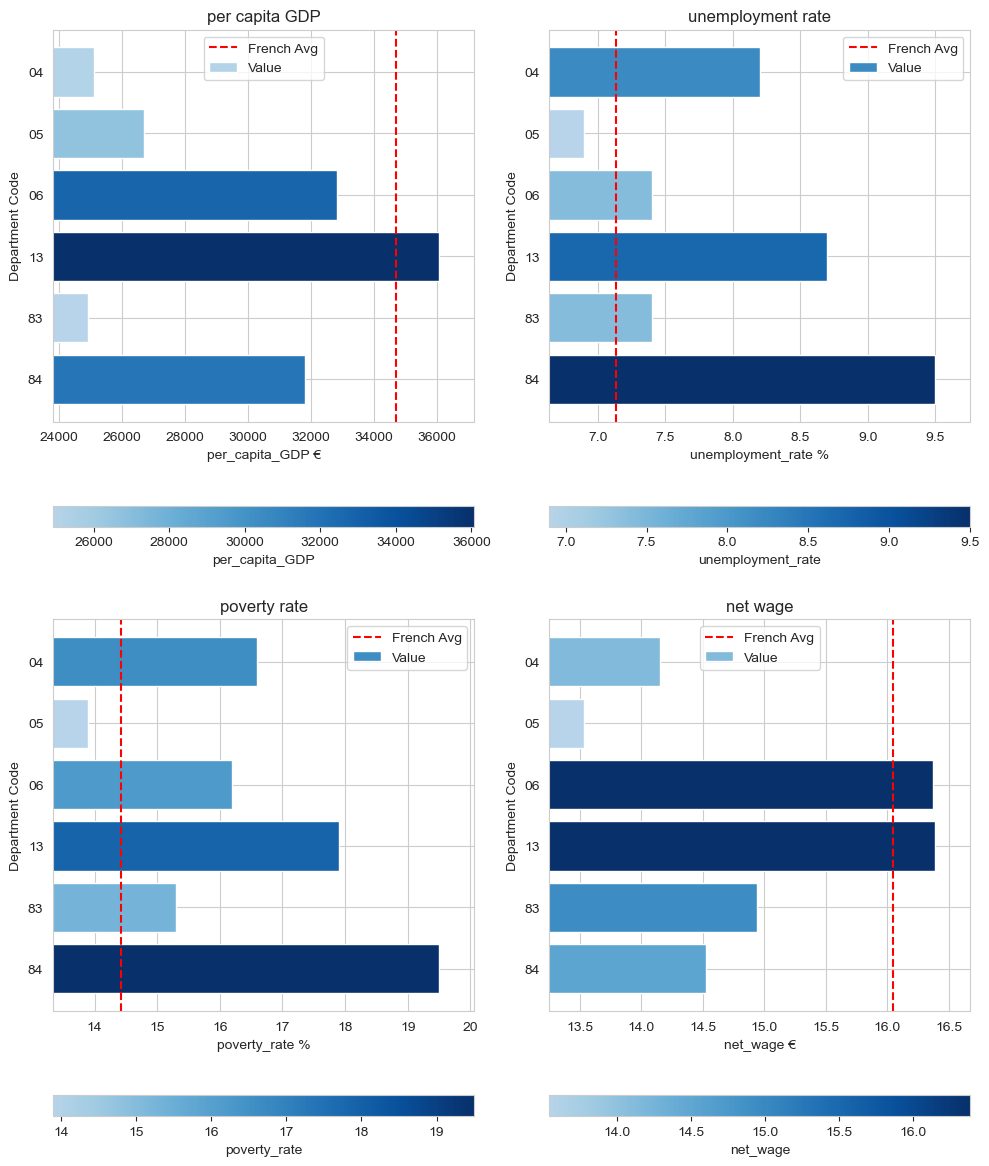

In [43]:
plot_side_by_side(paca_dept, cols_of_interest, french_means)

Only Bouches-du-Rhône (13) has a `per_capita_GDP` rate above the national average at 36072.35€. Its capital is Marseille which is the second most populous city in France and its metropolitan area is the third most populated in France behind Paris and Lyon. The city itself is divided into 16 municipal arrondissements in a similar way to Paris. Considering the economic diversity of the city and its administrative structure, the GDP value may fall far from providing a comprehensive picture.

5 out of 6 PACA departments are above the national average `poverty_rate` and `unemployment_rate`. 

Only Haute-Alpes (05) has a `poverty_rate` and `unemployment_rate` below the average along with the lowest (below national average) `net_wage` in PACA at 13.54€/hr. This is a mountainous and sparsely populated region bordering Savoie (73) to the North.

Alpes-Maritimes (06) has a `per_capita_GDP` of approx 32828.39€ which is above the weighted mean for France if we exclude Paris. It has a `net_wage` above the French average and relatively low (for the region) `unemployment_rate`. These are markers of economic health, and it is therefore surprising its poverty rate is so high at 16.2%. High wages, high poverty and low unemployment suggest income inequality. 

### Comparing `pop_density`, `poverty_rate` & `net_wage` at arrondissement level

**`pop_density`**: Provides a visualization of how populated or urbanized certain regions are. This is fundamental as denser areas might have different socio-economic challenges and opportunities than sparser ones.

**`poverty_rate`**: Gives an indication of socio-economic disparities within the regions.

**`net_wage`**: Wages give an idea of the affluence of regions. This, juxtaposed against poverty rates, offers an interesting contrast and can help highlight regions where disparities might be the most pronounced.

In [44]:
cols_of_interest = ['pop_density', 'poverty_rate', 'net_wage']
titles = ['Population Density', 'Poverty Rate (%)', 'Hourly Net Wage (€)']

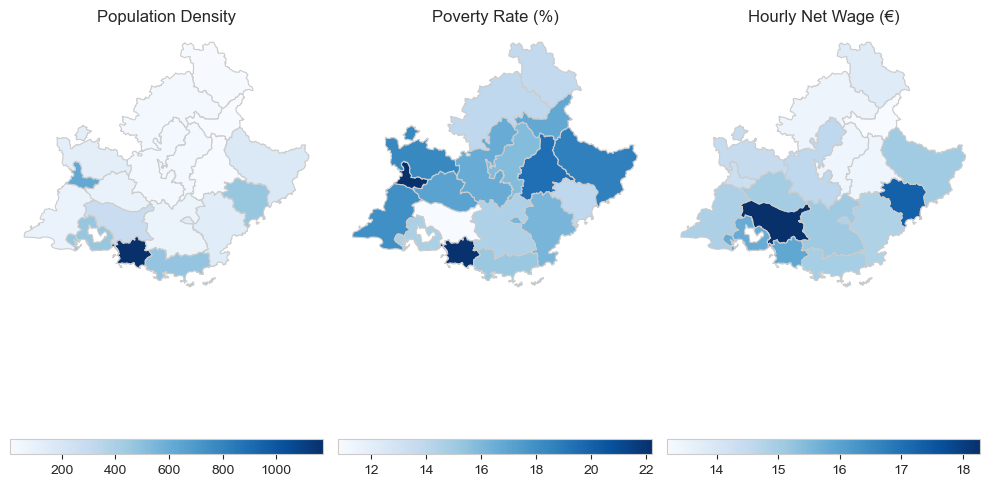

In [45]:
plot_multi_choropleth(paca_arron, cols_of_interest, titles, granularity='arrondissement', show_labels=False)

### We aggregate neighbouring departments and plot metrics

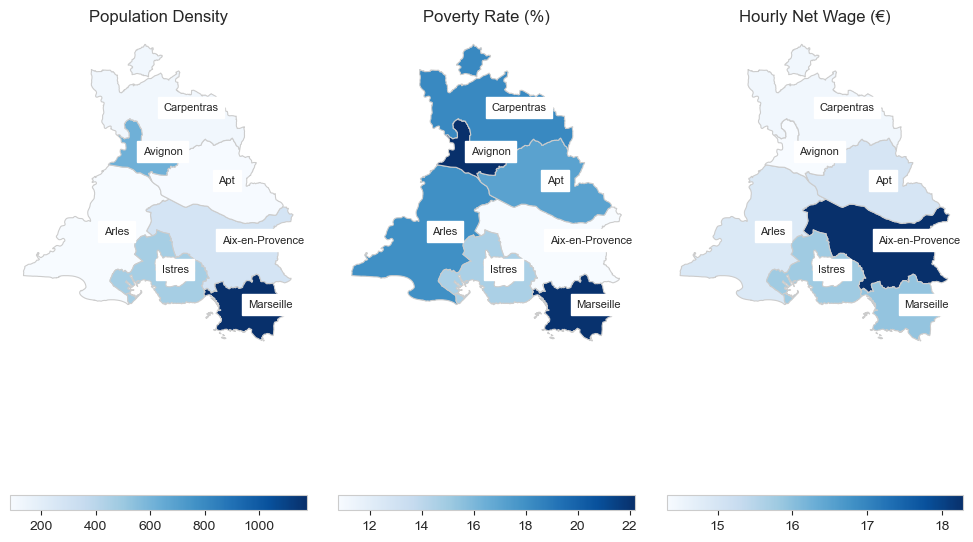

In [46]:
bouche_rhone_vaucluse = filter_dataframe(arrondissements, departments=['bouche du rhone', 'vaucluse'])
plot_multi_choropleth(bouche_rhone_vaucluse, cols_of_interest, titles, granularity='arrondissement', show_labels=True)

#### Bouches-du-Rhône (13) and Vaucluse (84) arrondissement outliers

**Marseille**: 
Population density of 1175 pax/km$^2$, a high `poverty_rate` of 22.1%, and a low `net_wage` of 15.91€/hr. 

**Aix-en_Provence**:
lowest `poverty_rate` at 10.8% and the highest `net_wage` at 18.28€/hr.

**Avignon**
It is the second most densely populated at 621 pax/km$^2$. Has the highest `poverty_rate` of 22.2% and lowest `net_wage` of 14.32€/hr.

Marseille has the greatest concentration of Michelin stars

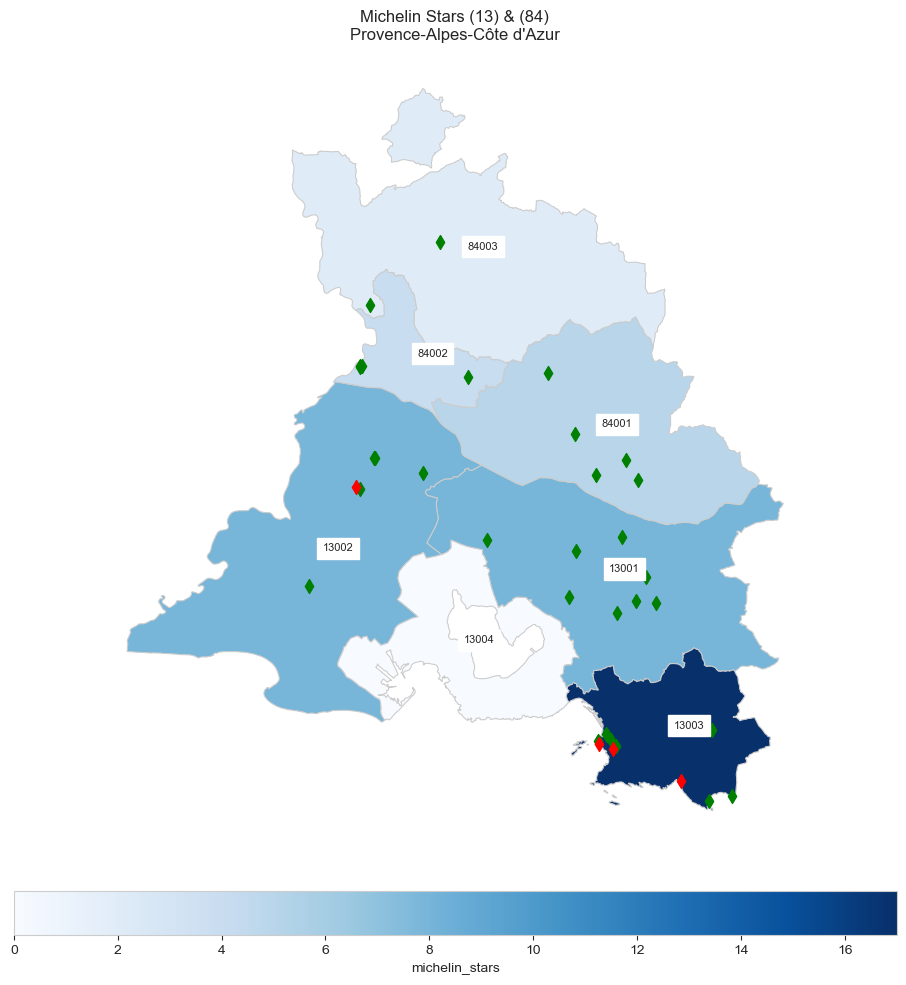

In [47]:
# Plotting michelin star restaurants
plot_choropleth(bouche_rhone_vaucluse, 'michelin_stars', 'Michelin Stars (13) & (84)',
                restaurants=True, show_legend=False)

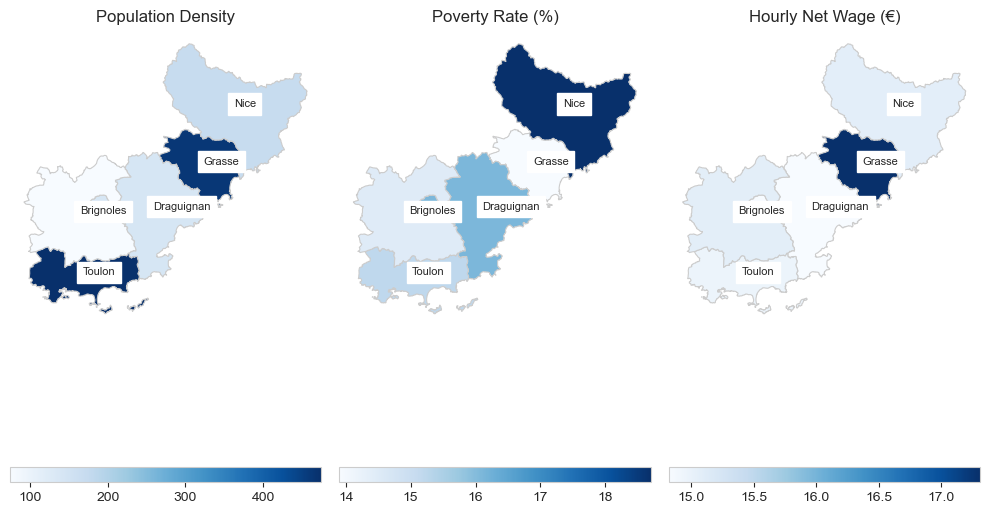

In [48]:
var_maritimes = filter_dataframe(arrondissements, departments=['alpes maritimes', 'var'])
plot_multi_choropleth(var_maritimes, cols_of_interest, titles, granularity='arrondissement', show_labels=True)

#### Alpes-Maritimes (06) and Var (83) arrondissement outliers

**Nice**
A relatively low population density of 172 pax/km$^2$, the highest `poverty_rate` at 18.7%, and a low `net_wage` of 15.07€/hr. 

**Grasse**
The second most densely populated at 463 pax/km$^2$, the lowest `poverty_rate` at 13.9%, and highest `net_wage` of 17.31€/hr.

**Toulon**
The most densely populated at 475 pax/km$^2$, a `poverty_rate` of 15.2% and `net_wage` of 14.96€/hr

Michelin star restaurants in Nice (06) are concentrated entirely along the coast.

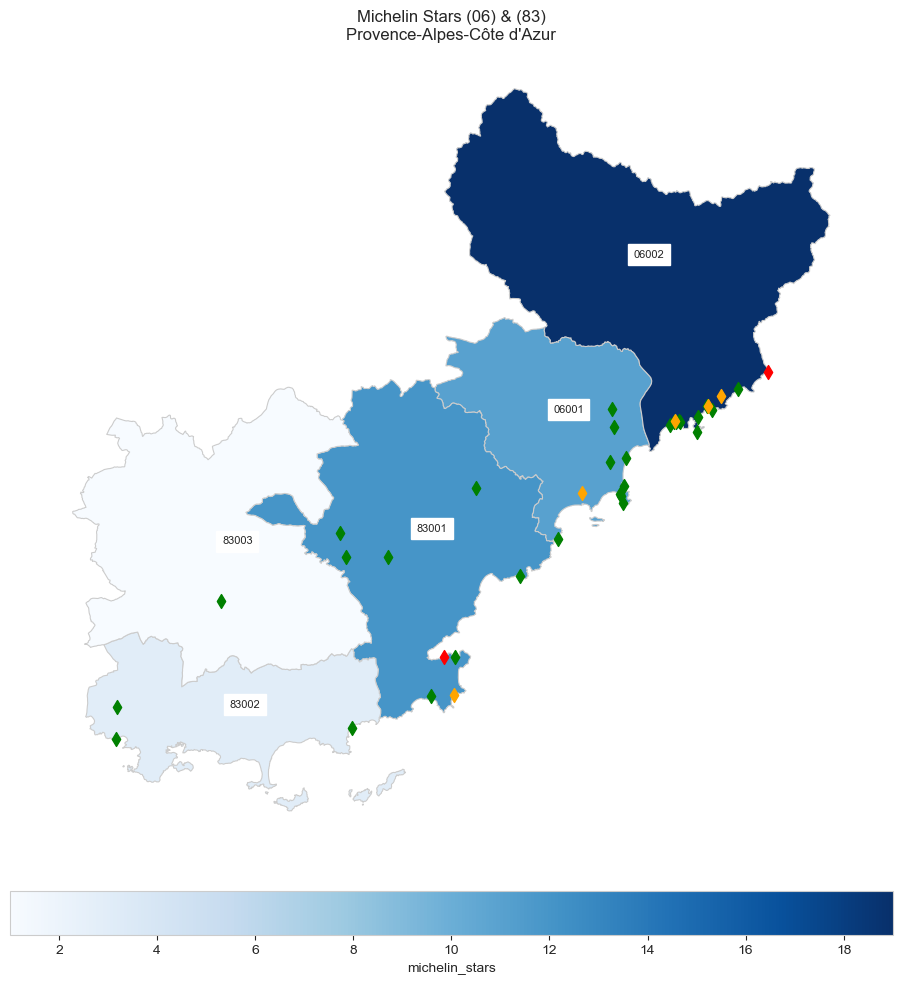

In [49]:
# Plotting michelin star restaurants
plot_choropleth(var_maritimes, 'michelin_stars', 'Michelin Stars (06) & (83)',
                restaurants=True, show_legend=False)

#### We plot the 'outlier' arrondissements to see how the values compare to the French mean.

In [50]:
outliers = ['nice', 'grasse', 'marseille', 'aix en provence', 'avignon', 'toulon']
outlier_paca = filter_dataframe(paca_arron, arrondissements=outliers)

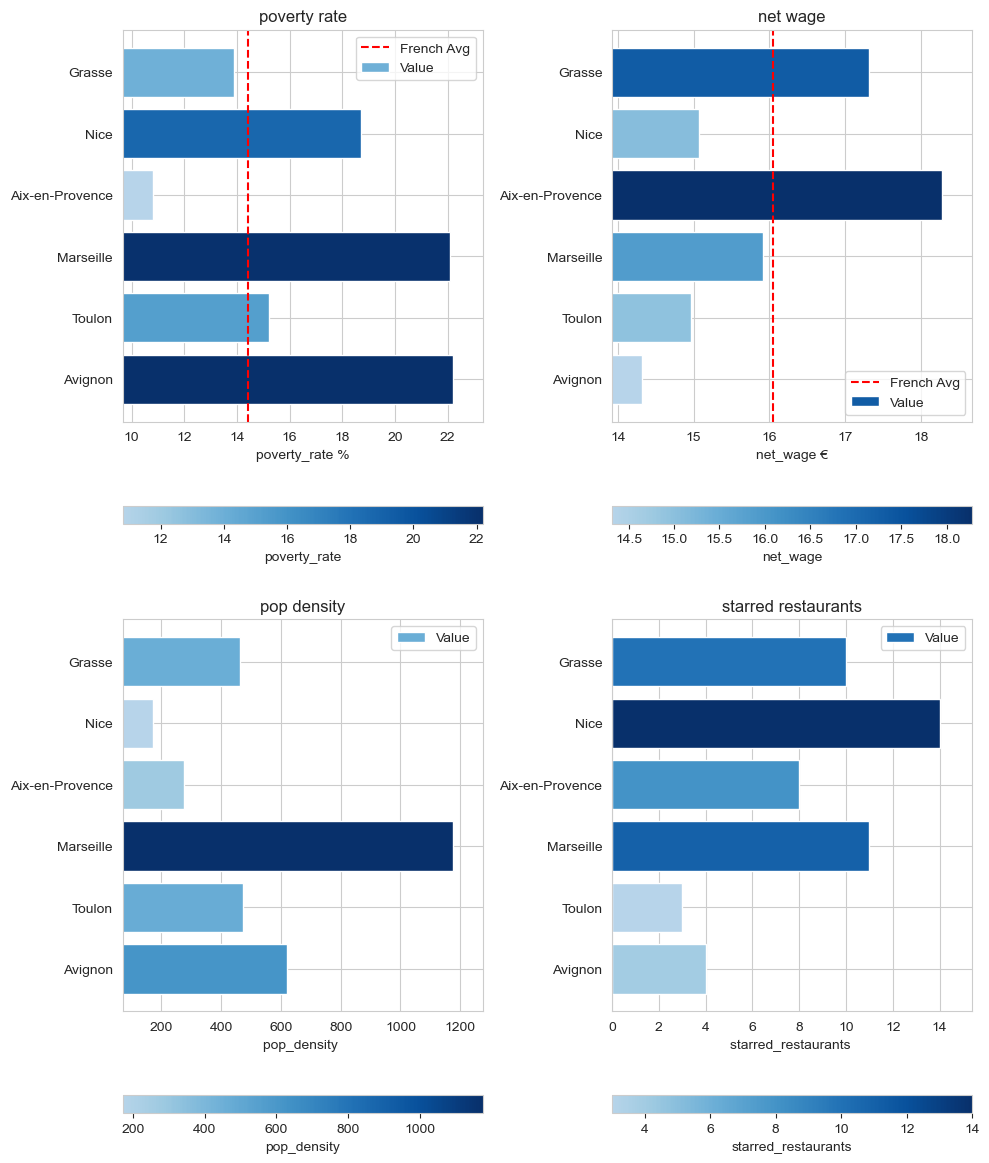

In [51]:
plot_side_by_side(outlier_paca, ['poverty_rate', 'net_wage', 'pop_density', 'starred_restaurants'],
                  french_means, granularity='arrondissement')

**Avignon**
Shows signs of economic distress with a `poverty_rate` and `net_wage` far above and below the French average.

**Marseille** 
Has a high `poverty_rate` and a low `net_wage` which is surprising considering its status as France's second-largest city. This hints at a great deal of regional inequality. Marseille illustrates the weakness of our data granularity, it's comprised of 16 arrondissement including *banlieues* (housing projects) with [poverty rates](https://cartotheque.anct.gouv.fr/media/record/eyJpIjoiZGVmYXVsdCIsIm0iOm51bGwsImQiOjEsInIiOjM1MH0=/) far exceeding the (already high) quoted figure along with high unemployment and organised crime.

**Aix-en_Provence**
Has a low `poverty_rate` and high `net_wage` which illustrates the importance of subdividing department into arrondissement to obtain a more complete picture. 

**Nice**
Fifth most populous city in France, its metropolitan population is close to 1 million inhabitants. Therefore, the low `pop_density` value is surprising but explained by the relative size of the arrondissement and the fact it includes sparsely populated upland areas. The conurbation borders the Mediterranean sea and spreads from Beaulieau-sur-mer in the east to Villeneuve-Loubet in the west (which is actually part of Grasse).
- It has a high `poverty_rate` and low `net_wage` which only hints at the inequality existent in the region. 
    - Nice Côte D’Azur airport is one of the busiest [private jet](https://btob.nice.aeroport.fr/business-aviation-and-helicopters) airports in the world. (2nd [2022](https://www.lunajets.com/en/jet-advices/which-5-business-airports-busiest-europe-2022))
    - The principality of Monaco with its many HNW 'citizens' is only 13km from Nice Old Town. 

**Grasse**
Below average `poverty_rate` and above average `net_wage`.
This densely populated region borders the Mediterranean from Cagnes-sur-Mer in the east to Cannes in the west. Antibes contains Port Vauban which is the largest yachting harbour in Europe. The extremely wealthy travel to this region.


**Monaco**
Included in the Michelin Guide to France is the principality of Monaco (Area: 2.02 sq_km), bordered by the Alpes-Maritimes on three-sides. I have purposely excluded Monaco from this analysis. However, it is noted here that the principality has 9 Michelin stars.

In [52]:
monaco = pd.read_csv("../../data/France/monaco.csv")
monaco = monaco[['name', 'award', 'city', 'price', 'cuisine']]
monaco

name             award  \
0     Le Louis XV - Alain Ducasse à l'Hôtel de Paris  3 MICHELIN Stars   
1                                        Le Blue Bay  2 MICHELIN Stars   
2                                           Le Grill   1 MICHELIN Star   
3                                              Yoshi   1 MICHELIN Star   
4  Pavyllon, un restaurant de Yannick Alléno, Mon...   1 MICHELIN Star   
5           La Table d'Antonio Salvatore au Rampoldi   1 MICHELIN Star   

     city price                                cuisine  
0  Monaco  €€€€  Mediterranean Cuisine, Modern Cuisine  
1  Monaco  €€€€                               Creative  
2  Monaco  €€€€                        Classic Cuisine  
3  Monaco  €€€€                               Japanese  
4  Monaco  €€€€               Modern Cuisine, Creative  
5  Monaco  €€€€                      Italian, Creative

----
&nbsp;
# *Occitanie*

In [53]:
occitanie_dept = filter_dataframe(departments, regions='Occitanie')
occitanie_arron = filter_dataframe(arrondissements, regions='Occitanie')

### Choropleth maps

Visualising the spread of `michelin_stars` and `pop_density` and department and arrondissement level

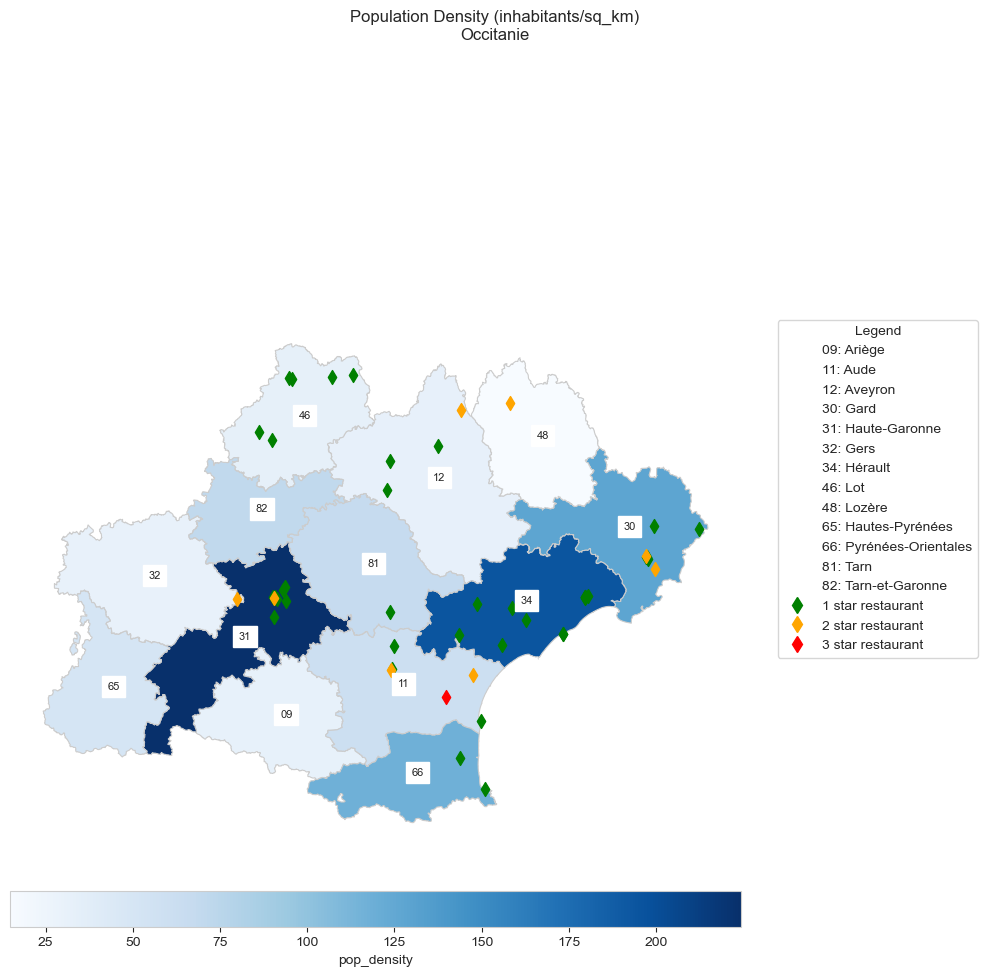

In [54]:
plot_choropleth(occitanie_dept, 'pop_density', 'Population Density (inhabitants/sq_km)', restaurants=True)

The two most densely populated departments are Haute-Garonne (31) and Hérault (34). We see Michelin star concentration in Haute-Garrone, Lot (46) and the departments bordering the Mediterranean. 

The ⭐️⭐️ [Bras](https://www.bras.fr/fr/) and ⭐️⭐️ [Restaurant Cyril Lattrazic](https://cyrilattrazic.fr/restaurant-gastronomique/) are Michelin outliers in sparsely populated Averyron (12) and Lozère (48) respectively

At arrondisement level, the cities of Toulouse (31), Montpelier (34) and Perpignon (66) are the most densely populated.

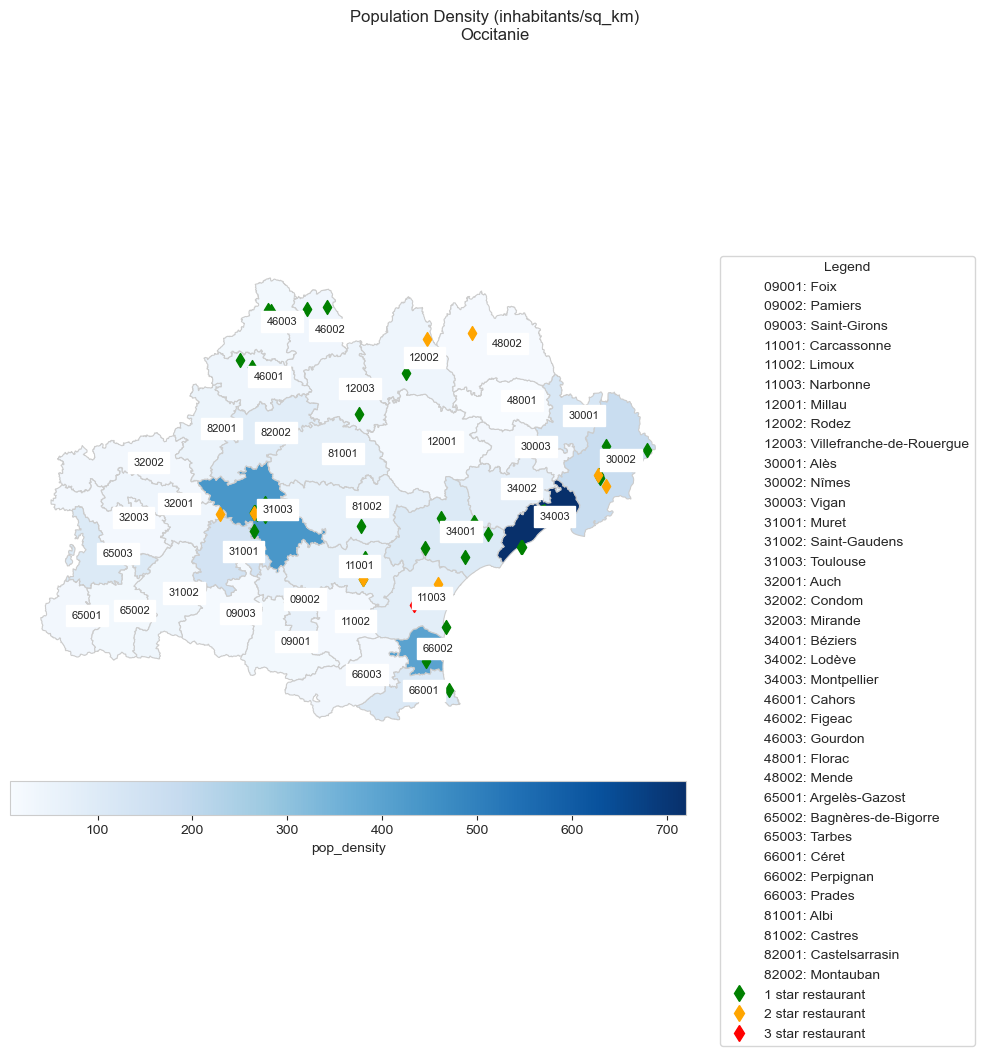

In [55]:
plot_choropleth(occitanie_arron, 'pop_density', 'Population Density (inhabitants/sq_km)',
                granularity='arrondissement', restaurants=True)

In [56]:
# We redefine our columns of interest. 
cols_of_interest = ['per_capita_GDP', 'unemployment_rate', 'poverty_rate', 'net_wage']
titles = ['GDP per capita (€)', 'Unemployment Rate (%)', 'Poverty Rate (%)', 'Hourly Net Wage (€)']
french_means = {'GDP': france_GDP,
                'poverty': france_poverty,
                'unemployment': france_unemployment,
                'wage': france_wage}

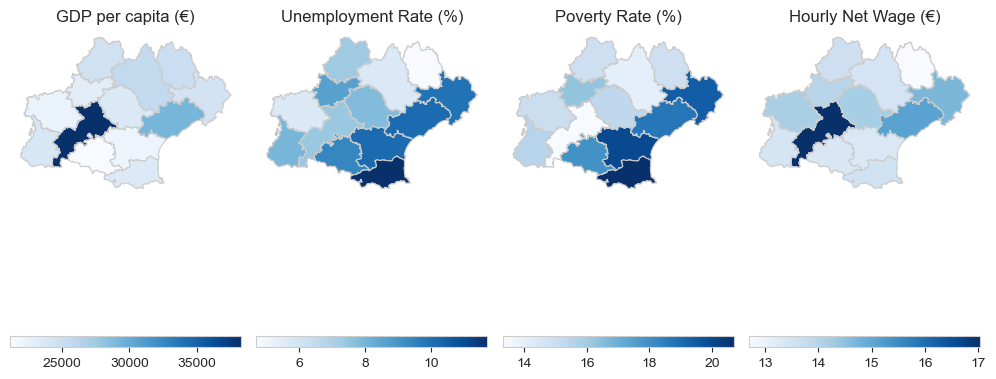

In [57]:
plot_multi_choropleth(occitanie_dept, cols_of_interest, titles, show_labels=False)

- Haute-Garrone (31) has the highest `per_capita_GDP` and `net_wage` along with the lowest `poverty_rate`

- Departments; Gard (30), Hérault (34), Aude (11) & Pyrénées-Orientales (66) have the greatest `poverty_rate` and `unemployment_rate`, indicative of economic distress. These departments (along with Lozère (48)) formed the former administrative region *Languedoc-Roussillon* which was merged with *Midi-Pyrénées* in 2016 to form *Occitanie* 

We have seen a strong positive correlation between `poverty_rate` | `unemployment_rate` in Occitanie and the above choropleth plot illustrates this. Unfortunately we cannot explore the spread of this relationship, `unemployment_rate` data has not been acquired at arrondissement level.

How do Occitan metrics compare with the French mean values?

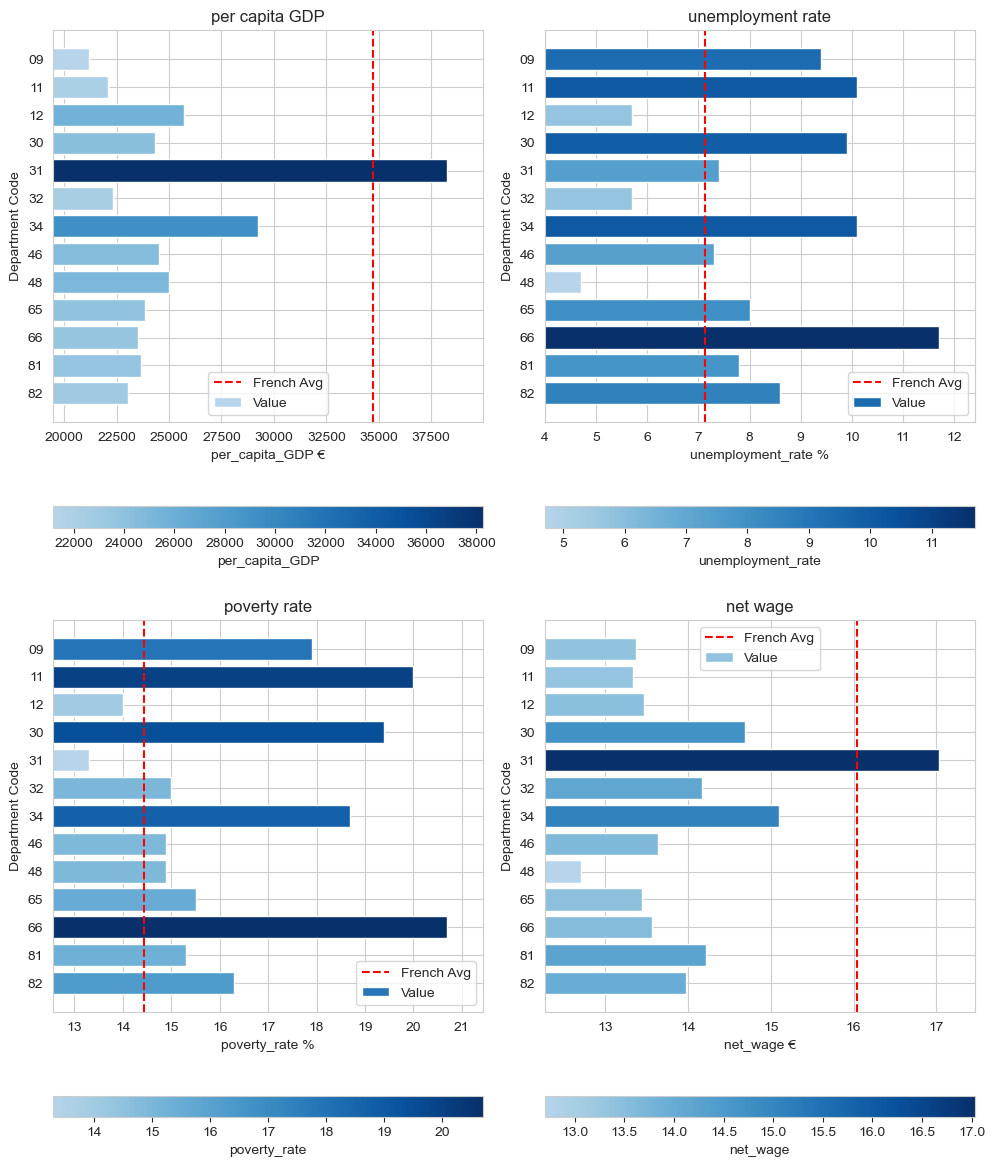

In [58]:
plot_side_by_side(occitanie_dept, cols_of_interest, french_means)

Only Haute-Garonne (31) has a `per_capita_GDP` and `net_wage` above the French average at 38265.18 € and 17.03 €/hr respectively. 

Its capital is Toulouse which is the fourth-largest city in France also the regional capital of Occitanie. Toulouse is the centre of the European aerospace industry with the headquarters of [Airbus](https://en.wikipedia.org/wiki/Airbus) and the [SPOT satellite system](https://en.wikipedia.org/wiki/SPOT_(satellite)). It is also the home of prestigious higher education schools. Toulouse's economy can rely on large industrial companies, research laboratories and a large pool of students, engineers and scientists. It's `poverty_rate` is below the national average at 13.3 %, with a slightly higher `unemployment_rate` of 7.4 %

Most departments in Occitanie rank below the French average for `net_wage` and `per_capita_GDP` and above the French average for `unemployment_rate` and `poverty_rate`. The exceptions are Aveyron (12) which is below the average `poverty_rate` and Lozère (48) which is below the average `poverty_rate` and `unemployment_rate`. 

We plot the whole South of France again against the above metrics

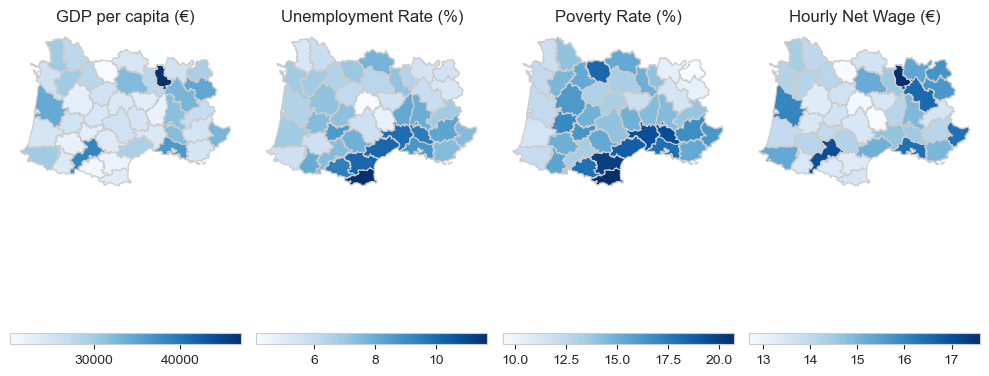

In [59]:
# Southern France as a whole
plot_multi_choropleth(south_dept, cols_of_interest, titles, granularity='department', show_labels=False)

Considering the entirety of Southern France in the above plot; Gard (30), Hérault (34), Aude (11) & Pyrénées-Orientales (66) have the classic markers of economic distress, 

- Low `GDP_per_capita`
- Low `net_wage`
- High `poverty_rate`
- High `unemployment_rate`

Ariege (09) and Lot (46) also stand out for the above metrics.

We compare together the 'Mediterranean departments', that is, departments formerly belonging to *Languedoc-Roussillon* together at department and arrondissement level to see if there is a degree of variation

In [60]:
# Defining Occitan 'Mediterranean departments'
med_depts = ['gard', 'aude', 'herault', 'pyrennes orientales']
med_dept = filter_dataframe(departments, departments=med_depts)
med_arron = filter_dataframe(arrondissements, departments=med_depts)

Department level

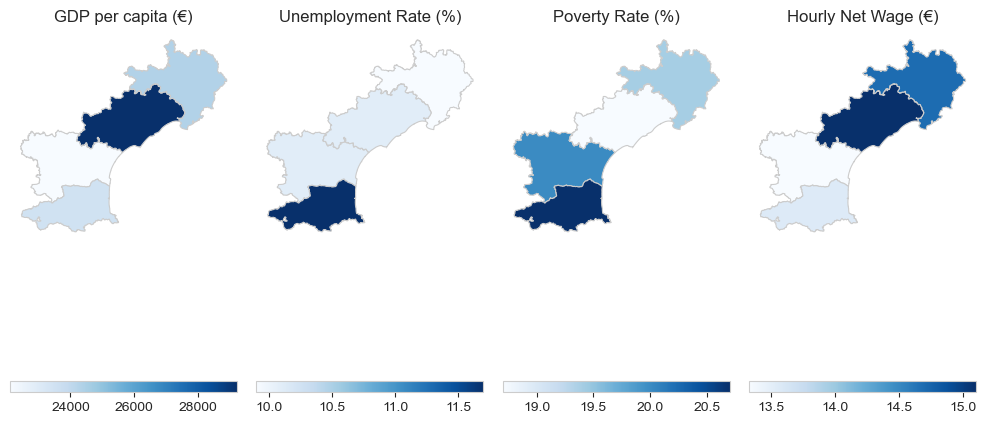

In [61]:
plot_multi_choropleth(med_dept, cols_of_interest, titles, granularity='department', show_labels=False)

Amongst the 'Mediterranean departments'; 

- Hérault (34) has the highest `per_capita_GDP` and lowest `poverty_rate` it was also the 9th department in the South of France for Michelin stars with 12.
- Gard (30) has the lowest `unemployment_rate` and highest `net_wage`
- Pyrénées-Orientales (66) appears to be in greatest economic distress.

We view these departments at arrondissement level to see if we find any variation.

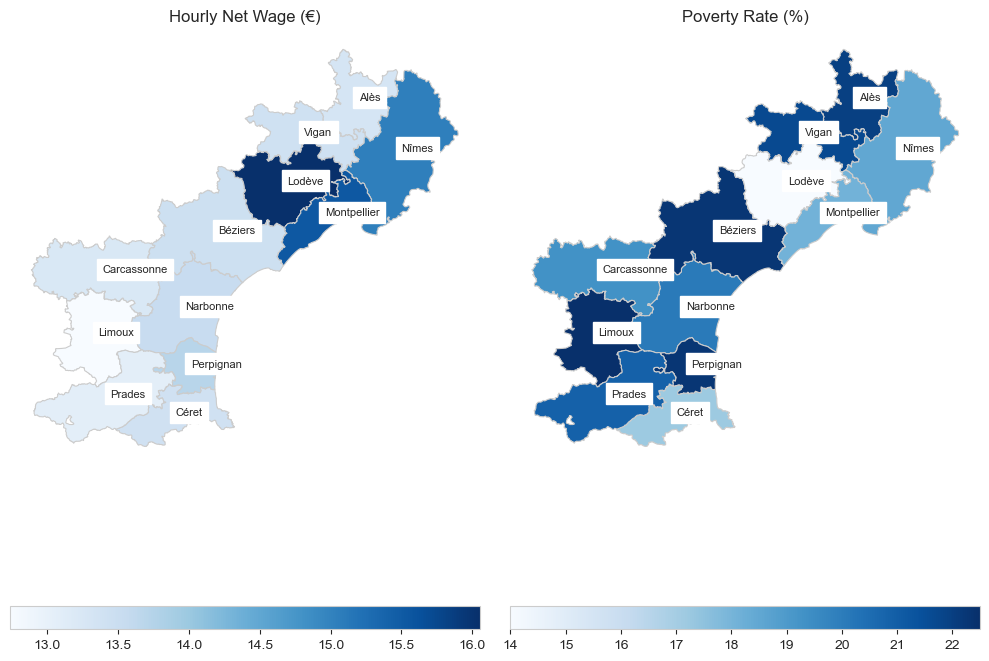

In [62]:
plot_multi_choropleth(med_arron, ['net_wage', 'poverty_rate'], 
                      ['Hourly Net Wage (€)', 'Poverty Rate (%)'], 
                      granularity='arrondissement', show_labels=True)

We overlay Michelin star restaurants

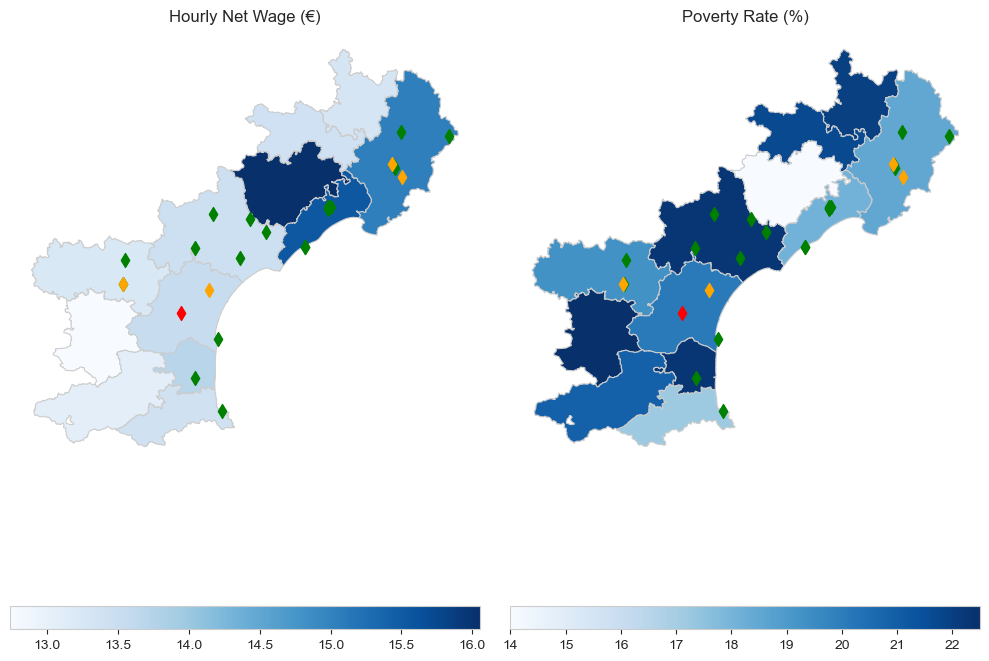

In [63]:
plot_multi_choropleth(med_arron, ['net_wage', 'poverty_rate'], 
                      ['Hourly Net Wage (€)', 'Poverty Rate (%)'], 
                      granularity='arrondissement', show_labels=False, restaurants=True)

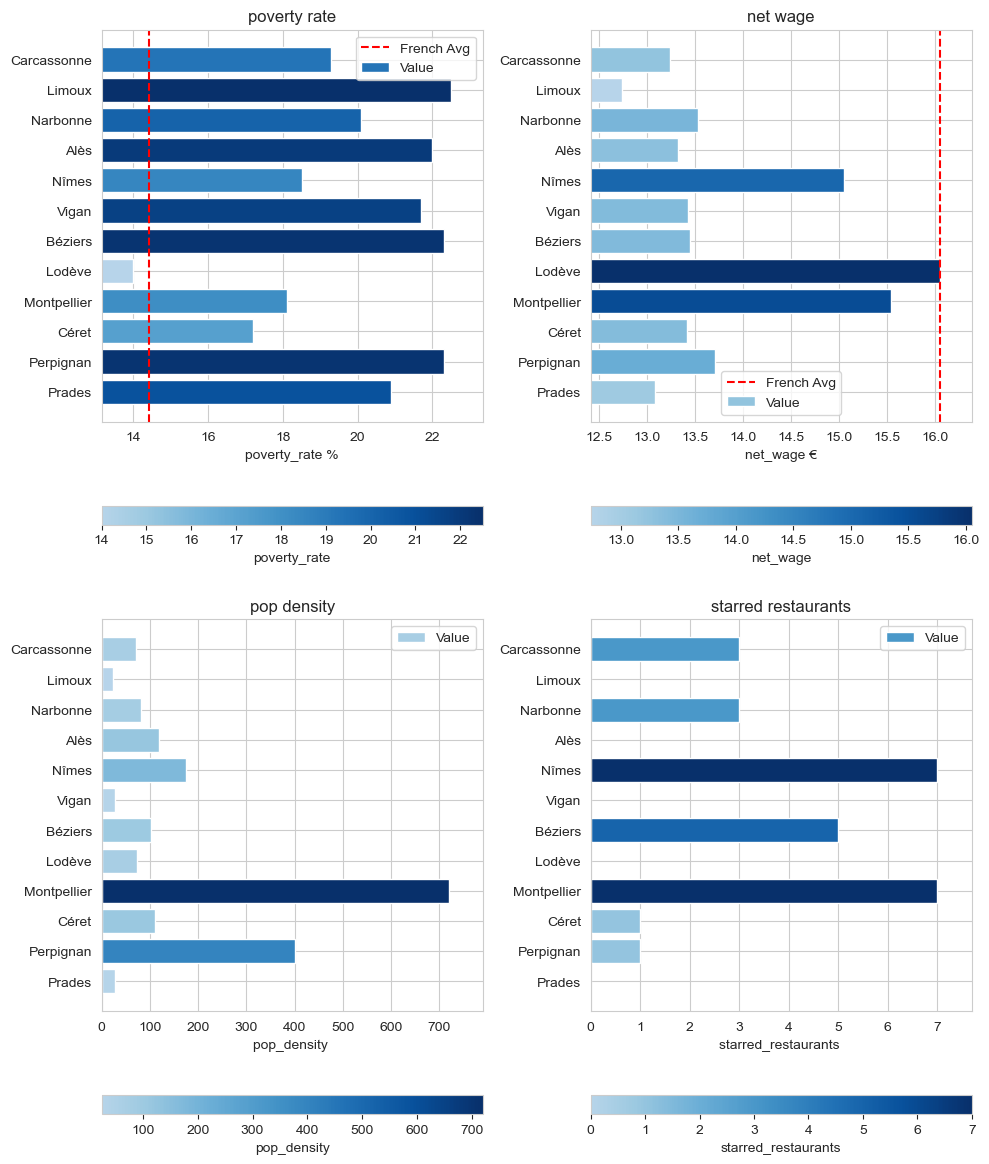

In [64]:
plot_side_by_side(med_arron, ['poverty_rate', 'net_wage', 'pop_density', 'starred_restaurants'],
                  french_means, granularity='arrondissement')

**Observations**
- Lodève in Hérault (34) has a below average `poverty_rate` and close to average `net_wage`. Montpellier (34) and Perpignan (66) have the greatest `pop_density`. 
- Nîmes (30), Béziers (34) & Montpellier (34) have the greatest concentration of Michelin stars. 
- Nîmes (30) & Montpellier (34) have the lowest `poverty_rate` and highest `net_wage` albeit above and below the French average respectively.

**Montpellier**
Seventh-largest city in France with a large student population, it was the capital of the *Languedoc-Rousillion* region which was dissolved in 2016. 

**Viticulture & Tourism**
Unique Draws:
- *Languedoc* is a major wine producing region. 
- There are UNESCO world heritage sites such as [*Canal du Midi*](https://en.wikipedia.org/wiki/Canal_du_Midi), [*Cite de Carcassone*](https://en.wikipedia.org/wiki/Cité_de_Carcassonne) and [*Pont du Gard*](https://en.wikipedia.org/wiki/Pont_du_Gard),  
- Diverse landscapes such as The Corbières and Cévennes National Parks.
- Numerous beaches and coastal resorts dotted along the Mediterranean. 

**Fishing & Aquaculture**
- **Sète**: Often referred to as the "Little Venice of Languedoc," Sète is the most prominent fishing port in the region. The town is not only known for its fishing but also for its seafood festival and rich maritime culture.
- **Étang de Thau**: Situated between Sète and Agde, this is one of the largest seawater lagoons in the Mediterranean. It's renowned for its oyster and mussel farming. The "Bouzigues oyster" is particularly famous and contributes significantly to the local economy.
- **Coastal Fisheries**: Small-scale fishing is widespread along the coast, providing local markets with fresh seafood. This not only supports local economies but also augments the region's gastronomic appeal. 

----

**Challenges: Poverty & Unemployment**
- **Seasonal Employment**: A lot of the job opportunities, especially in tourism, are seasonal. When the tourist season is over, many find themselves out of work.
- **Globalisation**: International competition, particularly in the wine industry, can pressure local producers. The wine of this region is fantastic but not world renowned. Producers may be at the mercy of large co-operatives who buy their grapes wholesale and dictate the price.
- **Rural/Urban Divide**: Whilst cities and coastal areas might see more development, inland and rural areas may lack the necessary infrastructure to support robust economic activities, leading to less investment, fewer job opportunities and economic disparity.


**Challenges in Fishing**
- **Overfishing**: The Mediterranean Sea faces challenges of overfishing, which can impact local fish stocks and, consequently, the livelihood of fishermen.
- **Environmental Concerns**: Pollution, coastal development, and climate change can affect marine ecosystems, impacting fish stocks and aquaculture production. This is tourism as a double-edged sword
- **Market Competition**: With the rise of large-scale fishing and imports, local fishermen might face challenges in getting competitive prices for their catch.

----
&nbsp;
### Michelin stars per 100,000 population

Regions - Whole France

In [65]:
regions = gpd.read_file("../../data/France/region_restaurants.geojson")
regions['stars_per_capita'] = regions['total_stars'] / regions['municipal_population'].where(regions['municipal_population'] != 0, 1)
regions['stars_per_100k_people'] = regions['stars_per_capita'] * 100000

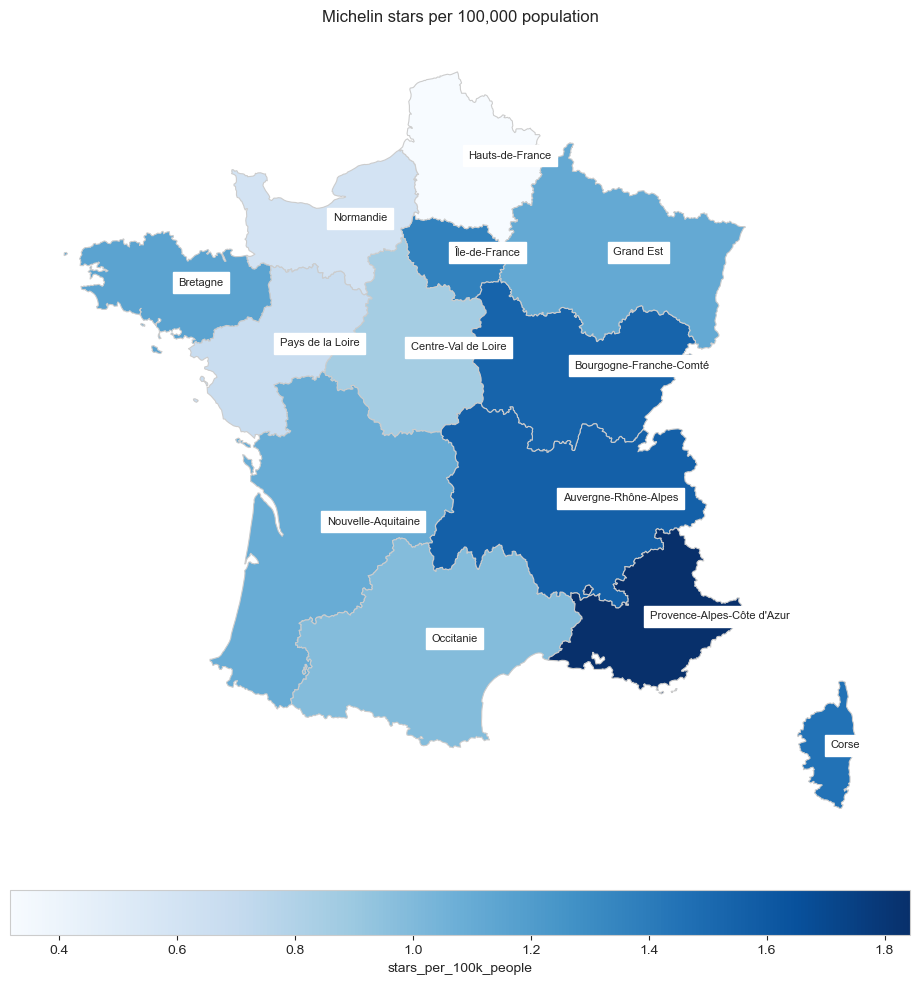

In [66]:
plot_choropleth(regions, 'stars_per_100k_people', 'Michelin stars per 100,000 population', granularity='region', show_legend=False)

Departments - South of France

In [67]:
south = filter_dataframe(departments, regions=['provence', 'occitanie', 'aquitaine', 'rhone alpes'])
south = south.copy()
south['stars_per_capita'] = south['michelin_stars'] / south['municipal_population'].where(south['municipal_population'] != 0, 1)
south['stars_per_100k_people'] = south['stars_per_capita'] * 100000

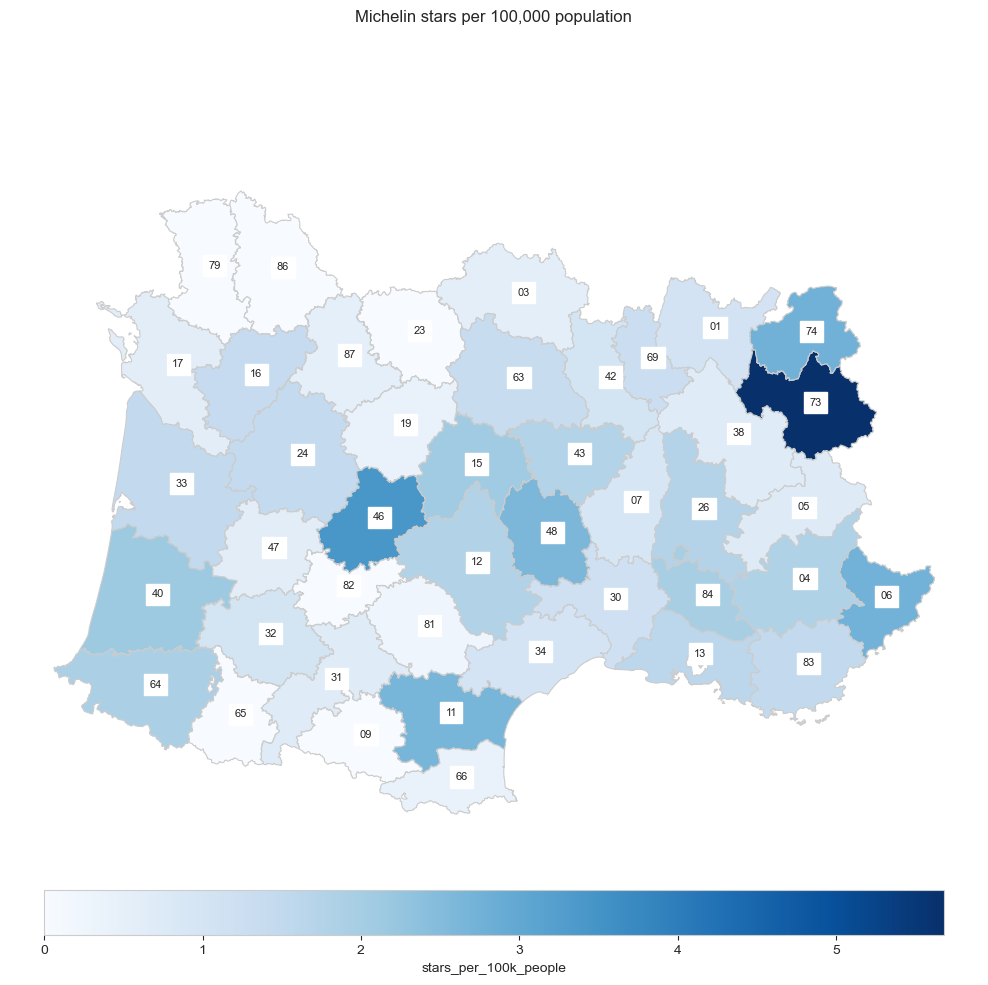

In [68]:
plot_choropleth(south, 'stars_per_100k_people', 'Michelin stars per 100,000 population', granularity='department', show_legend=False)

----
&nbsp;
# Conclusion

In analyzing the relationship between Michelin stars and various socio-economic metrics across the South of France with a deeper focus on PACA and Occitanie, several observations and challenges became evident:

**Data Consistency**: 
One of the main challenges faced during this analysis was the difficulty in pairing data from disparate sources. The Michelin Guide from 2023 was compared to INSEE data from 2020, leading to potential inconsistencies due to time lags.

**Impact of COVID-19**: It's essential to acknowledge the profound impact of the COVID-19 pandemic on the hospitality sector. With global disruptions and changes in consumer behavior, many establishments, including renowned restaurants, have faced severe financial hardships, some even succumbing to closure. This might have impacted the number and distribution of Michelin stars in more recent years.

**Potential for future temporal analysis**: 
Now that a foundational framework is in place, temporal data compilation would be a beneficial next step. Given that the Michelin Guide is released at the end of March each year, it would be insightful to analyze trends over time and observe shifts in star allocations and socio-economic metrics.

**Historical Context**: 
The original purpose of the Michelin Guide was to promote travel within France. As such, the association between Michelin stars and local tourism cannot be overlooked. There are instances where a singular renowned establishment can transform the socio-economic fabric of a region. Examples include; 
- The [Troisgros Dynasty](https://www.accountingfortasteblog.com/blog/troisgros-ouches-france) in Roanne (42)
    - Pierre Troisgros once noted that the restaurant used to be identified as being across the street from the train station. Now people identify the station as across the street from La Maison Troisgros.
- [BRAS](https://www.bras.fr/fr/) in Laguiole (12). 
    - [Sébastien Bras](https://www.theguardian.com/world/2017/sep/20/sebastien-bras-french-chef-three-michelin-stars-le-suquet-laguiole) handed back his 3 Michelin stars in 2017 indicating the pressure and expectations that come with such recognition. This underscores the complex relationship between such accolades and their broader implications. The restaurant currently has 2 Michelin stars.
- The above restaurants are situated in relatively remote regions, but their prominence has arguably drawn wealth and tourism. 

**Scope of Analysis**: 
While this analysis has focused on the pinnacle of hospitality, symbolized by Michelin stars, a holistic understanding might require a broader snapshot. Capturing metrics like the total number of restaurants or hotels could provide a more comprehensive picture of the region's hospitality landscape. However, the difficulty in collecting such data, especially in a consistent and reliable manner, is acknowledged.
&nbsp;
In essence, while Michelin stars serve as a notable metric for excellence in the culinary world, their interplay with socio-economic factors is multifaceted. Regions with prominent Michelin-starred establishments often enjoy increased tourism and associated economic benefits. Yet, the challenges faced by the industry, exacerbated by recent global events, highlight the need for continuous and adaptive analysis.

----
&nbsp;
## Post Script: Wine Regions

We view the intersection of Michlin stars and the major wine growing regions of France

[Geo Data Source](https://github.com/UCDavisLibrary/wine-ontology/blob/master/examples/france/regions.geojson)

In [100]:
wine_data = gpd.read_file("../../data/France/Wine/regions.geojson")
dataframe_info(wine_data)

GeoDataFrame.
Unique Regions: 9

Shape: (136, 6)


region  url2 url1                name                    grapes  \
0  Region Rhône   NaN               Côte-Rôtie            Syrah,Viognier   
1  Region Rhône   NaN       Condrieu/St.Joseph                  Viognier   
2  Region Rhône   NaN                St.Joseph  Syrah,Marsanne,Roussanne   

                                            geometry  
0  POLYGON ((4.83635 45.50525, 4.82852 45.50103, ...  
1  POLYGON ((4.76009 45.34456, 4.75093 45.34191, ...  
2  POLYGON ((4.85263 44.97935, 4.83995 44.98130, ...

In [101]:
print(f"\nUnique Regions:\n{wine_data.region.unique().tolist()}")


Unique Regions:
['Region Rhône', 'region Provence', 'region Loire', 'region Bordeaux', 'region Languedoc-Roussillon', 'region Dordogne', 'region Champagne', 'region Bourgogne', 'region Alsace']


In [102]:
# Remove the word 'Region' from 'region' columns
wine_data['region'] = wine_data['region'].str.replace('Region ', '', case=False)
wine_data = wine_data[['region', 'geometry']]
wine_data.head()

region                                           geometry
0  Rhône  POLYGON ((4.83635 45.50525, 4.82852 45.50103, ...
1  Rhône  POLYGON ((4.76009 45.34456, 4.75093 45.34191, ...
2  Rhône  POLYGON ((4.85263 44.97935, 4.83995 44.98130, ...
3  Rhône  POLYGON ((4.83304 45.15733, 4.83995 45.15636, ...
4  Rhône  POLYGON ((4.85263 44.97944, 4.85565 44.95945, ...

Adding regional colours

In [103]:
# Color mapping for wine regions
wine_region_colors = {
    'Rhône': 'maroon',          
    'Provence': 'plum',         
    'Loire': 'olive',           
    'Bordeaux': 'navy',         
    'Languedoc-Roussillon': 'purple',  
    'Dordogne': 'sienna',       
    'Champagne': 'goldenrod',   
    'Bourgogne': 'teal',        
    'Alsace': 'darkslategray'   
}

wine_data['colours'] = wine_data['region'].map(wine_region_colors)

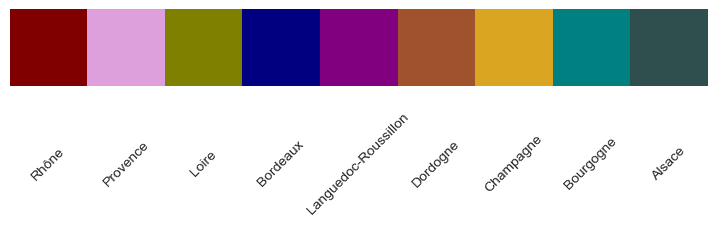

In [117]:
wine_palette = [wine_region_colors[region] for region in wine_region_colors]
# Plot the palette
sns.palplot(wine_palette)
# Label the colors by region below each block:
for idx, region in enumerate(wine_region_colors.keys()):
    plt.text(idx, 1.5, region, ha='center', va='center', rotation=45, fontsize=10)
plt.gca().axis('off')
plt.show()

In [104]:
from Functions.functions_wine import plot_choropleth_wine

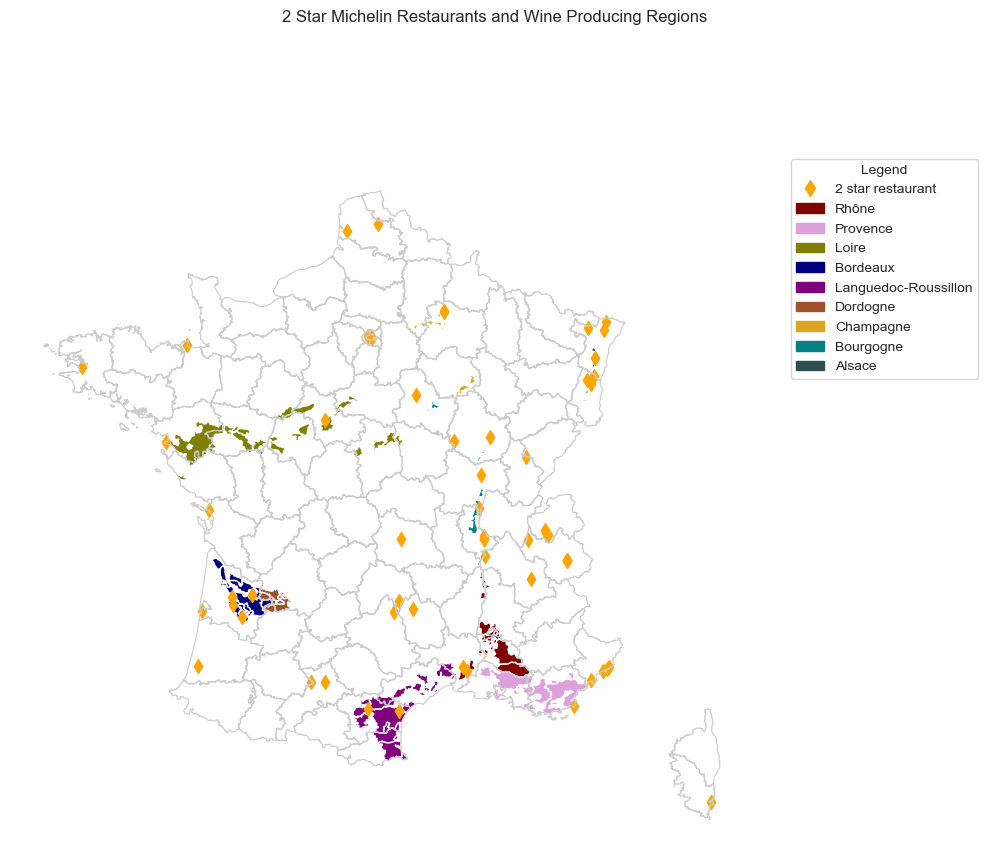

In [105]:
plot_choropleth_wine(departments, wine_data, '2 Star Michelin Restaurants and Wine Producing Regions', restaurants=True, star_rating=2)

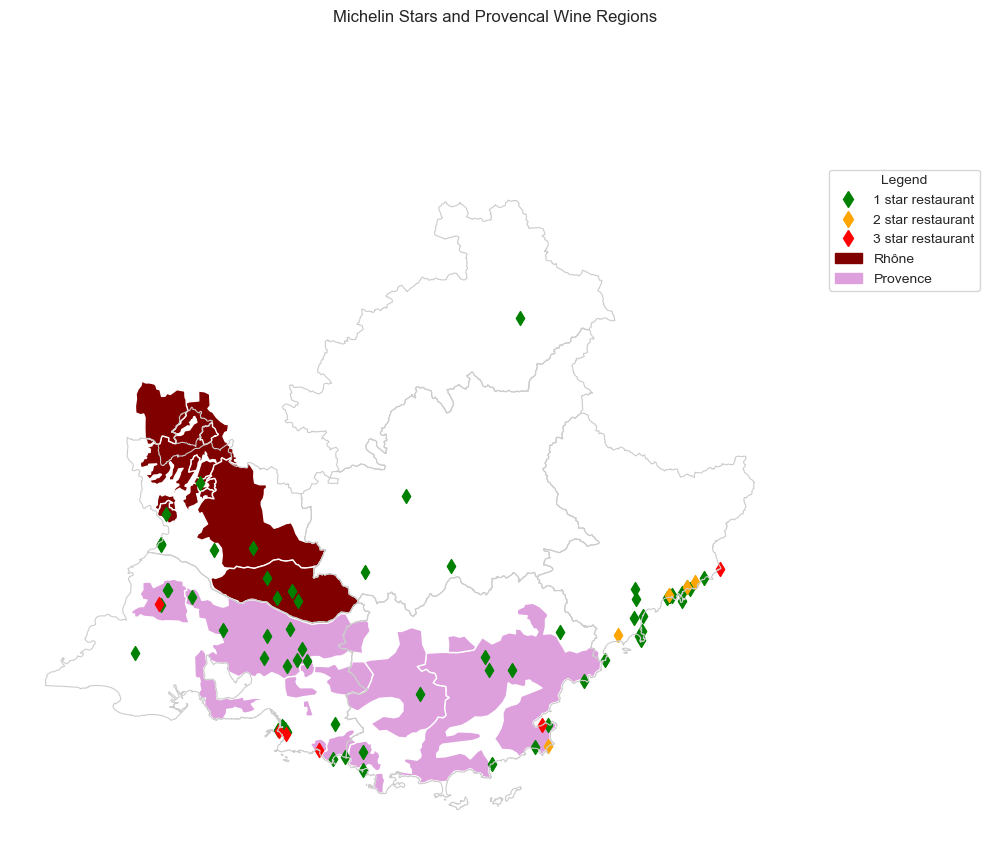

In [106]:
plot_choropleth_wine(paca_dept, wine_data, 'Michelin Stars and Provencal Wine Regions', restaurants=True)

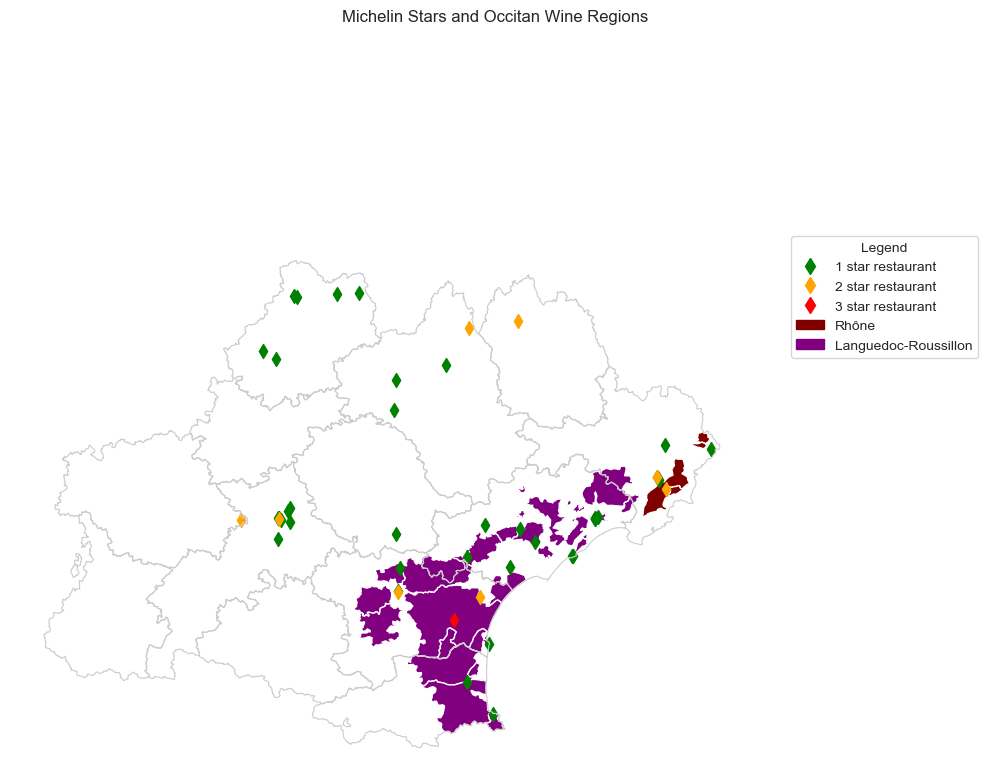

In [107]:
plot_choropleth_wine(occitanie_dept, wine_data, 'Michelin Stars and Occitan Wine Regions', restaurants=True)